# GP2Vec Training Prototype

This notebook demonstrates the complete GP2Vec training pipeline using small synthetic datasets for rapid prototyping and testing. We'll walk through:

1. **Data Generation**: Create synthetic seismic-like waveforms
2. **Model Architecture**: Build a simplified GP2Vec model
3. **Training Pipeline**: Train with PyTorch Lightning
4. **Evaluation**: Test the learned representations
5. **Visualization**: Monitor training progress and results

This prototype uses small batches and limited data to enable fast iteration and debugging of the self-supervised learning approach.

## 1. Import Required Libraries

First, let's import all the necessary libraries for our GP2Vec prototype.

In [1]:
# Core libraries
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
sys.path.insert(0, str(project_root))


### Install GP2Vec Package

Before we can import the gp2vec modules, we need to install the package in development mode. This allows us to use the source code directly without copying files.

In [2]:
# Install gp2vec in development mode
import subprocess
import sys

# Get the project root (parent of notebooks directory)
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()

# Install gp2vec in development mode
print(f"Installing gp2vec from: {project_root}")
result = subprocess.run(
    [sys.executable, "-m", "pip", "install", "-e", str(project_root)],
    capture_output=True,
    text=True
)

if result.returncode == 0:
    print("✅ Successfully installed gp2vec in development mode")
else:
    print("⚠️ Installation output:")
    print(result.stdout)
    if result.stderr:
        print("Errors:")
        print(result.stderr)

Installing gp2vec from: /Users/marinedenolle/GitHub/FoundationModel_GP
✅ Successfully installed gp2vec in development mode
✅ Successfully installed gp2vec in development mode


In [3]:

# Scientific computing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.stats import norm
from tqdm.auto import tqdm
from datetime import datetime, timezone, timedelta
from datetimerange import DateTimeRange

# PyTorch and Lightning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, RichProgressBar
from pytorch_lightning.loggers import CSVLogger

# ObsPy for seismic data
import obspy
from obspy import UTCDateTime, Stream, Trace
from obspy.clients.fdsn import Client

# S3 and cloud data access
import s3fs
import boto3
from botocore import UNSIGNED
from botocore.config import Config


In [4]:
# GP2Vec modules - import after installation
try:
    from gp2vec.models.gp2vec import GP2Vec
    from gp2vec.models.feature_encoder import FeatureEncoder
    from gp2vec.models.vq import GumbelVectorQuantizer
    from gp2vec.models.transformer import TransformerContextEncoder
    from gp2vec.models.losses import GP2VecLoss
    print("✓ Successfully imported GP2Vec modules")
except ImportError as e:
    print(f"⚠ Could not import GP2Vec modules: {e}")
    print("We'll define simplified versions in this notebook")

# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set random seeds for reproducibility
pl.seed_everything(42)

print("📦 All libraries imported successfully!")
print(f"🔧 PyTorch version: {torch.__version__}")
print(f"⚡ Lightning version: {pl.__version__}")
print(f"🌍 ObsPy version: {obspy.__version__}")
print(f"🖥️  Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")


Seed set to 42


✓ Successfully imported GP2Vec modules
📦 All libraries imported successfully!
🔧 PyTorch version: 2.5.1
⚡ Lightning version: 2.5.6
🌍 ObsPy version: 1.4.2
🖥️  Device: CPU


In [5]:

# Test S3 connectivity
try:
    # Test anonymous access to SCEDC bucket
    s3 = s3fs.S3FileSystem(anon=True)
    bucket_contents = s3.ls('scedc-pds/continuous_waveforms/')
    print(f"✅ S3 connection successful! Found {len(bucket_contents)} directories in SCEDC bucket")
except Exception as e:
    print(f"⚠️ S3 connection issue: {e}")
    print("Will fall back to synthetic data if needed")

✅ S3 connection successful! Found 28 directories in SCEDC bucket


In [6]:
# from gp2vec.data.datastore import Dataset, ChannelCatalog, Channel, ChannelType, Station

class SCEDCSeismicDataset(Dataset):
    """
    PyTorch dataset for loading real seismic data from SCEDC S3 bucket.
    
    The SCEDC provides continuous seismic waveforms organized as:
    s3://scedc-pds/continuous_waveforms/{year}/{year}_{julian_day:03d}/
    Files are named: {network}{station}{channel}{location}{year}{julian_day}.ms
    e.g., CIGMR__LHN___2022002.ms or CE13884HNZ10_2022002.ms
    """
    
    def __init__(
        self,
        start_date="2023-01-01",
        num_days=3,  # Small number for prototyping
        networks=["CI"],  # Start with CI network
        stations=["ADE", "ADO", "BAR"],  # Select a few stations
        channels=["BHE", "BHN", "BHZ"],  # 3-component broadband
        sample_length_sec=30.0,  # 30-second windows
        sample_rate=100.0,  # Target sample rate
        samples_per_day=10,  # Small number for prototyping
        transform=None
    ):
        super().__init__()
        
        self.start_date = datetime.strptime(start_date, "%Y-%m-%d")
        self.num_days = num_days
        self.networks = networks
        self.stations = stations
        self.channels = channels
        self.sample_length_sec = sample_length_sec
        self.sample_rate = sample_rate
        self.samples_per_day = samples_per_day
        self.transform = transform
        self.sample_length_pts = int(sample_length_sec * sample_rate)
        
        # Initialize S3 filesystem (anonymous access)
        self.fs = s3fs.S3FileSystem(anon=True)
        self.bucket = "scedc-pds"
        self.base_path = "continuous_waveforms"
        
        # Build list of available data files
        self._build_file_list()
        
        # Station metadata cache
        self.station_metadata = {}
    
    def _parse_channel_from_filename(self, filename: str) -> dict:
        """
        Parse SCEDC filename format: {network}{station}{channel}{location}{year}{julian_day}.ms
        Examples:
        - CIGMR__LHN___2022002.ms -> network=CI, station=GMR, channel=LHN, location='', year=2022, day=002
        - CE13884HNZ10_2022002.ms -> network=CE, station=13884, channel=HNZ, location='10', year=2022, day=002
        """
        # Remove .ms extension and path
        basename = filename.split('/')[-1].replace('.ms', '')
        
        # Extract components following SCEDCS3DataStore pattern
        network = basename[:2]
        station = basename[2:7].rstrip("_")
        channel = basename[7:10]
        location = basename[10:12].strip("_")
        year = int(basename[-7:-3])
        day = int(basename[-3:])
        
        return {
            'network': network,
            'station': station,
            'channel': channel,
            'location': location,
            'year': year,
            'julian_day': day
        }
        
    def _build_file_list(self):
        """Build list of available miniSEED files for the specified parameters."""
        self.file_list = []
        
        for day_offset in range(self.num_days):
            current_date = self.start_date + timedelta(days=day_offset)
            year = current_date.year
            julian_day = current_date.timetuple().tm_yday
            
            # Use SCEDCS3DataStore path pattern
            day_path = f"{self.base_path}/{year}/{year}_{julian_day:03d}"
            
            try:
                # List all files for this day
                full_path = f"{self.bucket}/{day_path}"
                print(f"Searching: {full_path}")
                files = self.fs.glob(f"{full_path}/*.ms")
                print(f"Found {len(files)} total files on {current_date.strftime('%Y-%m-%d')}")
                
                # Group by station and location
                station_files = {}
                
                for file_path in files:
                    filename = file_path.split('/')[-1]
                    
                    try:
                        parsed = self._parse_channel_from_filename(filename)
                        
                        # Filter by network and station
                        if parsed['network'] not in self.networks:
                            continue
                        if parsed['station'] not in self.stations:
                            continue
                        
                        # Create station key
                        key = f"{parsed['network']}_{parsed['station']}_{parsed['location']}"
                        
                        if key not in station_files:
                            station_files[key] = {
                                'network': parsed['network'],
                                'station': parsed['station'],
                                'location': parsed['location'],
                                'channels': {}
                            }
                        
                        # Store file path for this channel
                        station_files[key]['channels'][parsed['channel']] = f"s3://{file_path}"
                        
                    except Exception as e:
                        print(f"Warning: Could not parse {filename}: {e}")
                        continue
                
                # Add complete 3-component sets
                for station_key, station_info in station_files.items():
                    available_channels = set(station_info['channels'].keys())
                    target_channels = set(self.channels)
                    
                    # Check if we have at least 2 components (can work with incomplete sets)
                    if len(available_channels.intersection(target_channels)) >= 2:
                        self.file_list.append({
                            'date': current_date,
                            'station_key': station_key,
                            'files': station_info['channels'],
                            'network': station_info['network'],
                            'station': station_info['station'],
                            'location': station_info['location']
                        })
                        print(f"  Added {station_key} with channels: {list(station_info['channels'].keys())}")
                        
            except Exception as e:
                print(f"Warning: Could not access {day_path}: {e}")
                continue
        
        print(f"\nTotal: {len(self.file_list)} station-days with multi-component data")
        
    def _get_station_metadata(self, network, station):
        """Get station metadata from SCEDC FDSN."""
        key = f"{network}.{station}"
        
        if key not in self.station_metadata:
            try:
                # Use ObsPy to get station metadata
                from obspy.clients.fdsn import Client
                client = Client("SCEDC")
                
                # Get station info (try recent date)
                inventory = client.get_stations(
                    network=network, station=station,
                    starttime=UTCDateTime("2023-01-01"),
                    level="station"
                )
                
                if inventory:
                    net = inventory[0]
                    sta = net[0]
                    self.station_metadata[key] = {
                        'latitude': sta.latitude,
                        'longitude': sta.longitude,
                        'elevation': sta.elevation,
                        'creation_date': sta.creation_date,
                        'site_name': sta.site.name if sta.site else "Unknown"
                    }
                else:
                    # Fallback metadata
                    self.station_metadata[key] = {
                        'latitude': 34.0,  # Rough SoCal center
                        'longitude': -118.0,
                        'elevation': 100.0,
                        'creation_date': UTCDateTime("2000-01-01"),
                        'site_name': "Unknown"
                    }
                    
            except Exception as e:
                print(f"Warning: Could not get metadata for {key}: {e}")
                # Fallback metadata
                self.station_metadata[key] = {
                    'latitude': 34.0 + np.random.uniform(-2, 2),
                    'longitude': -118.0 + np.random.uniform(-2, 2),
                    'elevation': 100.0 + np.random.uniform(-50, 500),
                    'creation_date': UTCDateTime("2000-01-01"),
                    'site_name': "Unknown"
                }
        
        return self.station_metadata[key]
    
    def __len__(self):
        return len(self.file_list) * self.samples_per_day
    
    def __getitem__(self, idx):
        # Determine which station-day and which sample within that day
        file_idx = idx // self.samples_per_day
        sample_idx = idx % self.samples_per_day
        
        if file_idx >= len(self.file_list):
            raise IndexError(f"Index {idx} out of range")
            
        file_info = self.file_list[file_idx]
        
        try:
            # Load waveform data
            waveforms = []
            channel_names = []
            
            for channel in self.channels:
                if channel in file_info['files']:
                    file_path = file_info['files'][channel]
                    print(file_path)
                    # Read miniSEED file from S3
                    with self.fs.open(file_path, 'rb') as f:
                        st = obspy.read(f, format='MSEED')
                    
                    if st and len(st) > 0:
                        tr = st[0]  # Take first trace
                        
                        # Basic preprocessing
                        tr.detrend('linear')
                        tr.filter('bandpass', freqmin=1.0, freqmax=45.0)
                        
                        # Resample if needed
                        if abs(tr.stats.sampling_rate - self.sample_rate) > 0.1:
                            tr.resample(self.sample_rate)
                        
                        waveforms.append(tr.data)
                        channel_names.append(channel)
                
            if len(waveforms) == 0:
                raise ValueError("No valid waveforms found")
            
            # Ensure all traces have the same length
            min_length = min(len(w) for w in waveforms)
            if min_length < self.sample_length_pts:
                # Pad with zeros if too short
                for i in range(len(waveforms)):
                    if len(waveforms[i]) < self.sample_length_pts:
                        waveforms[i] = np.pad(waveforms[i], 
                                            (0, self.sample_length_pts - len(waveforms[i])), 
                                            'constant')
                min_length = self.sample_length_pts
            
            # Extract random window
            if min_length > self.sample_length_pts:
                max_start = min_length - self.sample_length_pts
                start_idx = np.random.randint(0, max_start + 1)
                waveforms = [w[start_idx:start_idx + self.sample_length_pts] for w in waveforms]
            
            # Stack to create 3-component array (pad with zeros if needed)
            while len(waveforms) < 3:
                waveforms.append(np.zeros(self.sample_length_pts))
                channel_names.append("PAD")
            
            # Take only first 3 components
            waveforms = waveforms[:3]
            channel_names = channel_names[:3]
            
            data = np.stack(waveforms, axis=0).astype(np.float32)
            
            # Normalize each component
            for i in range(data.shape[0]):
                std = np.std(data[i])
                if std > 0:
                    data[i] = data[i] / std
            
            # Get station metadata
            metadata = self._get_station_metadata(file_info['network'], file_info['station'])
            
            # Create metadata tensor (normalized coordinates)
            metadata_tensor = torch.tensor([
                (metadata['latitude'] - 34.0) / 5.0,  # Normalize around SoCal
                (metadata['longitude'] + 118.0) / 5.0,
                metadata['elevation'] / 1000.0,  # Convert to km
                float(metadata['creation_date'].timestamp) / 1e9  # Normalize timestamp
            ], dtype=torch.float32)
            
            sample = {
                'waveform': torch.from_numpy(data),
                'metadata': metadata_tensor,
                'station_id': f"{file_info['network']}.{file_info['station']}",
                'date': file_info['date'].strftime("%Y-%m-%d"),
                'channels': channel_names
            }
            
            if self.transform:
                sample = self.transform(sample)
                
            return sample
            
        except Exception as e:
            print(f"Error loading data for index {idx}: {e}")
            # Return dummy data in case of error
            dummy_data = np.random.randn(3, self.sample_length_pts).astype(np.float32)
            dummy_metadata = torch.zeros(4, dtype=torch.float32)
            
            return {
                'waveform': torch.from_numpy(dummy_data),
                'metadata': dummy_metadata,
                'station_id': "DUMMY.DUMMY",
                'date': "2023-01-01",
                'channels': ["ERR", "ERR", "ERR"]
            }

## Handling Variable Sampling Rates: Strategies and Implementation

When working with seismic data from different networks, instruments, or time periods, you'll encounter various sampling rates (1 Hz, 20 Hz, 40 Hz, 100 Hz, 200 Hz, etc.). Here are several approaches to handle this diversity:

### Strategy 1: Multi-Rate Resampling with Adaptive Windows
- **Concept**: Maintain multiple target sampling rates and choose the most appropriate one for each trace
- **Benefits**: Preserves signal fidelity, avoids unnecessary downsampling
- **Implementation**: Use adaptive window lengths based on sampling rate

### Strategy 2: Frequency-Domain Feature Encoding
- **Concept**: Convert to frequency domain first, then standardize frequency bins
- **Benefits**: Naturally handles different sampling rates, focuses on spectral content
- **Implementation**: FFT → standardized frequency grid → feature extraction

### Strategy 3: Multi-Scale Convolutional Encoder
- **Concept**: Use different conv layers for different sampling rate groups
- **Benefits**: Learns optimal features for each sampling rate
- **Implementation**: Route data through different encoder branches

### Strategy 4: Time-Duration Normalization
- **Concept**: Keep fixed time duration but variable number of samples
- **Benefits**: Preserves all original information, lets model learn from raw temporal patterns
- **Implementation**: Pad/truncate sequences, use attention masking

In [ ]:
class MultiRateSeismicDataset(Dataset):
    """
    Advanced seismic dataset that handles multiple sampling rates intelligently.
    
    Implements several strategies:
    1. Multi-rate resampling with quality preservation
    2. Adaptive window sizing
    3. Frequency-domain standardization option
    4. Variable sequence length handling
    """
    
    def __init__(
        self,
        start_date="2023-01-01",
        num_days=3,
        networks=["CI"],
        stations=["ADE", "ADO", "BAR"],
        channels=["BHE", "BHN", "BHZ"],
        sample_length_sec=30.0,
        sampling_strategy="adaptive",  # "adaptive", "unified", "preserve", "frequency_domain"
        target_rates=[20.0, 40.0, 100.0],  # Multiple target rates
        samples_per_day=10,
        transform=None,
        min_rate=1.0,  # Minimum acceptable sampling rate
        max_rate=1000.0,  # Maximum acceptable sampling rate
    ):
        super().__init__()
        
        self.start_date = datetime.strptime(start_date, "%Y-%m-%d")
        self.num_days = num_days
        self.networks = networks
        self.stations = stations
        self.channels = channels
        self.sample_length_sec = sample_length_sec
        self.sampling_strategy = sampling_strategy
        self.target_rates = sorted(target_rates)
        self.samples_per_day = samples_per_day
        self.transform = transform
        self.min_rate = min_rate
        self.max_rate = max_rate
        
        # Initialize S3 filesystem
        self.fs = s3fs.S3FileSystem(anon=True)
        self.bucket = "scedc-pds"
        self.base_path = "continuous_waveforms"
        
        # Build file list with sampling rate metadata
        self._build_file_list_with_rates()
        
        # Station metadata cache
        self.station_metadata = {}
        
        # Precompute strategy-specific parameters
        self._setup_sampling_strategy()
    
    def _setup_sampling_strategy(self):
        """Setup parameters based on chosen sampling strategy."""
        if self.sampling_strategy == "adaptive":
            # Use different target rates for different original rates
            self.rate_mapping = self._compute_adaptive_mapping()
        elif self.sampling_strategy == "unified":
            # Single target rate (highest available)
            self.unified_rate = max(self.target_rates)
        elif self.sampling_strategy == "preserve":
            # Keep original rates, handle variable lengths
            self.max_samples = int(self.sample_length_sec * max(self.target_rates))
        elif self.sampling_strategy == "frequency_domain":
            # Standardized frequency bins
            self.n_fft = 512
            self.freq_bins = self.n_fft // 2 + 1
    
    def _compute_adaptive_mapping(self):
        """Compute mapping from original rates to target rates."""
        rate_mapping = {}
        for orig_rate in np.arange(self.min_rate, self.max_rate + 1, 1.0):
            # Find the best target rate (closest but not exceeding original)
            valid_targets = [r for r in self.target_rates if r <= orig_rate * 1.1]
            if valid_targets:
                rate_mapping[orig_rate] = max(valid_targets)
            else:
                rate_mapping[orig_rate] = min(self.target_rates)
        return rate_mapping
    
    def _get_sampling_rate_from_file(self, file_path: str) -> Optional[float]:
        """Efficiently extract sampling rate from miniSEED file header."""
        try:
            with self.fs.open(file_path, 'rb') as f:
                # Read just enough to get the fixed header
                header_data = f.read(64)
                
            # Extract sampling rate from miniSEED header
            # This is a simplified extraction - in practice, you'd use obspy
            # For demo purposes, we'll simulate different rates
            import hashlib
            file_hash = int(hashlib.md5(file_path.encode()).hexdigest()[:8], 16)
            
            # Simulate realistic sampling rates for seismic data
            possible_rates = [1.0, 20.0, 40.0, 50.0, 100.0, 200.0, 500.0]
            return possible_rates[file_hash % len(possible_rates)]
            
        except Exception as e:
            logger.warning(f"Could not extract sampling rate from {file_path}: {e}")
            return None
    
    def _build_file_list_with_rates(self):
        """Build file list with sampling rate metadata."""
        self.file_list = []
        
        for day_offset in range(self.num_days):
            current_date = self.start_date + timedelta(days=day_offset)
            year = current_date.year
            julian_day = current_date.timetuple().tm_yday
            
            day_path = f"{self.base_path}/{year}/{year}_{julian_day:03d}"
            
            try:
                full_path = f"{self.bucket}/{day_path}"
                files = self.fs.glob(f"{full_path}/*.ms")
                
                station_files = {}
                
                for file_path in files:
                    filename = file_path.split('/')[-1]
                    
                    try:
                        parsed = self._parse_channel_from_filename(filename)
                        
                        if parsed['network'] not in self.networks:
                            continue
                        if parsed['station'] not in self.stations:
                            continue
                        
                        # Get sampling rate
                        s3_path = f"s3://{file_path}"
                        sampling_rate = self._get_sampling_rate_from_file(s3_path)
                        
                        if sampling_rate is None:
                            continue
                        
                        key = f"{parsed['network']}_{parsed['station']}_{parsed['location']}"
                        
                        if key not in station_files:
                            station_files[key] = {
                                'network': parsed['network'],
                                'station': parsed['station'],
                                'location': parsed['location'],
                                'channels': {}
                            }
                        
                        station_files[key]['channels'][parsed['channel']] = {
                            'file_path': s3_path,
                            'sampling_rate': sampling_rate
                        }
                        
                    except Exception as e:
                        continue
                
                # Add multi-component sets
                for station_key, station_info in station_files.items():
                    available_channels = set(station_info['channels'].keys())
                    target_channels = set(self.channels)
                    
                    if len(available_channels.intersection(target_channels)) >= 2:
                        self.file_list.append({
                            'date': current_date,
                            'station_key': station_key,
                            'files': station_info['channels'],
                            'network': station_info['network'],
                            'station': station_info['station'],
                            'location': station_info['location']
                        })
                        
            except Exception as e:
                continue
        
        print(f"Total: {len(self.file_list)} station-days with multi-rate data")
    
    def _parse_channel_from_filename(self, filename: str) -> dict:
        """Parse SCEDC filename - same as before."""
        basename = filename.split('/')[-1].replace('.ms', '')
        
        network = basename[:2]
        station = basename[2:7].rstrip("_")
        channel = basename[7:10]
        location = basename[10:12].strip("_")
        year = int(basename[-7:-3])
        day = int(basename[-3:])
        
        return {
            'network': network,
            'station': station,
            'channel': channel,
            'location': location,
            'year': year,
            'julian_day': day
        }
    
    def _load_and_process_trace(self, file_info: dict, channel: str) -> Optional[dict]:
        """Load and process a single trace with rate-aware processing."""
        if channel not in file_info:
            return None
        
        file_path = file_info[channel]['file_path']
        original_rate = file_info[channel]['sampling_rate']
        
        try:
            # Read miniSEED file
            with self.fs.open(file_path, 'rb') as f:
                st = obspy.read(f, format='MSEED')
            
            if not st or len(st) == 0:
                return None
            
            tr = st[0]
            
            # Basic preprocessing
            tr.detrend('linear')
            
            # Strategy-specific processing
            if self.sampling_strategy == "adaptive":
                target_rate = self.rate_mapping.get(original_rate, self.target_rates[0])
                processed_data = self._process_adaptive_rate(tr, target_rate)
                
            elif self.sampling_strategy == "unified":
                processed_data = self._process_unified_rate(tr, self.unified_rate)
                
            elif self.sampling_strategy == "preserve":
                processed_data = self._process_preserve_rate(tr)
                
            elif self.sampling_strategy == "frequency_domain":
                processed_data = self._process_frequency_domain(tr)
            
            else:
                raise ValueError(f"Unknown sampling strategy: {self.sampling_strategy}")
            
            return {
                'data': processed_data['data'],
                'rate': processed_data['rate'],
                'n_samples': processed_data['n_samples'],
                'channel': channel,
                'original_rate': original_rate
            }
            
        except Exception as e:
            logger.warning(f"Error processing {file_path}: {e}")
            return None
    
    def _process_adaptive_rate(self, trace: obspy.Trace, target_rate: float) -> dict:
        """Process trace with adaptive resampling."""
        # Apply anti-aliasing filter if downsampling significantly
        if trace.stats.sampling_rate > target_rate * 2:
            nyquist = target_rate / 2.0
            trace.filter('lowpass', freq=nyquist * 0.9, corners=4)
        
        # Resample if needed
        if abs(trace.stats.sampling_rate - target_rate) > 0.1:
            trace.resample(target_rate)
        
        # Extract window
        n_samples = int(self.sample_length_sec * target_rate)
        if len(trace.data) >= n_samples:
            start_idx = np.random.randint(0, len(trace.data) - n_samples + 1)
            data = trace.data[start_idx:start_idx + n_samples]
        else:
            # Pad if too short
            data = np.pad(trace.data, (0, n_samples - len(trace.data)), 'constant')
        
        return {
            'data': data.astype(np.float32),
            'rate': target_rate,
            'n_samples': n_samples
        }
    
    def _process_unified_rate(self, trace: obspy.Trace, target_rate: float) -> dict:
        """Process trace by resampling to unified rate."""
        return self._process_adaptive_rate(trace, target_rate)
    
    def _process_preserve_rate(self, trace: obspy.Trace) -> dict:
        """Process trace preserving original sampling rate."""
        original_rate = trace.stats.sampling_rate
        n_samples_target = int(self.sample_length_sec * original_rate)
        
        if len(trace.data) >= n_samples_target:
            start_idx = np.random.randint(0, len(trace.data) - n_samples_target + 1)
            data = trace.data[start_idx:start_idx + n_samples_target]
        else:
            # Pad to target length
            data = np.pad(trace.data, (0, n_samples_target - len(trace.data)), 'constant')
        
        # Pad or truncate to max_samples for batch consistency
        if len(data) > self.max_samples:
            # Downsample to fit
            step = len(data) // self.max_samples
            data = data[::step][:self.max_samples]
        else:
            # Pad with zeros
            data = np.pad(data, (0, self.max_samples - len(data)), 'constant')
        
        return {
            'data': data.astype(np.float32),
            'rate': original_rate,
            'n_samples': len(data)
        }
    
    def _process_frequency_domain(self, trace: obspy.Trace) -> dict:
        """Process trace in frequency domain for rate-invariant features."""
        # Compute STFT or FFT
        from scipy import signal
        
        # Extract window
        original_rate = trace.stats.sampling_rate
        n_samples = int(self.sample_length_sec * original_rate)
        
        if len(trace.data) >= n_samples:
            start_idx = np.random.randint(0, len(trace.data) - n_samples + 1)
            data = trace.data[start_idx:start_idx + n_samples]
        else:
            data = np.pad(trace.data, (0, n_samples - len(trace.data)), 'constant')
        
        # Compute power spectral density
        f, psd = signal.welch(data, fs=original_rate, nperseg=min(self.n_fft, len(data)))
        
        # Standardize to common frequency grid (0 to 50 Hz)
        target_freqs = np.linspace(0, 50, self.freq_bins)
        psd_interp = np.interp(target_freqs, f, psd)
        
        # Log transform and normalize
        psd_log = np.log10(psd_interp + 1e-10)
        
        return {
            'data': psd_log.astype(np.float32),
            'rate': None,  # Rate-invariant
            'n_samples': len(psd_log)
        }
    
    def __len__(self):
        return len(self.file_list) * self.samples_per_day
    
    def __getitem__(self, idx):
        file_idx = idx // self.samples_per_day
        sample_idx = idx % self.samples_per_day
        
        if file_idx >= len(self.file_list):
            raise IndexError(f"Index {idx} out of range")
        
        file_info = self.file_list[file_idx]
        
        try:
            # Load waveform data for all available channels
            channel_data = []
            channel_names = []
            sampling_rates = []
            
            for channel in self.channels:
                trace_data = self._load_and_process_trace(file_info['files'], channel)
                
                if trace_data is not None:
                    channel_data.append(trace_data['data'])
                    channel_names.append(channel)
                    sampling_rates.append(trace_data['rate'])
                else:
                    # Create dummy data matching the expected shape
                    if self.sampling_strategy == "frequency_domain":
                        dummy_shape = self.freq_bins
                    elif self.sampling_strategy == "preserve":
                        dummy_shape = self.max_samples
                    else:
                        # Adaptive/unified strategies
                        dummy_shape = int(self.sample_length_sec * self.target_rates[0])
                    
                    channel_data.append(np.zeros(dummy_shape, dtype=np.float32))
                    channel_names.append(f"MISSING_{channel}")
                    sampling_rates.append(None)
            
            # Ensure we have exactly 3 channels (pad if needed)
            while len(channel_data) < 3:
                if self.sampling_strategy == "frequency_domain":
                    dummy_shape = self.freq_bins
                elif self.sampling_strategy == "preserve":
                    dummy_shape = self.max_samples
                else:
                    dummy_shape = int(self.sample_length_sec * self.target_rates[0])
                
                channel_data.append(np.zeros(dummy_shape, dtype=np.float32))
                channel_names.append("PAD")
                sampling_rates.append(None)
            
            # Take only first 3 channels
            channel_data = channel_data[:3]
            channel_names = channel_names[:3]
            sampling_rates = sampling_rates[:3]
            
            # Stack into tensor
            data = np.stack(channel_data, axis=0).astype(np.float32)
            
            # Normalize each channel
            for i in range(data.shape[0]):
                if np.std(data[i]) > 0:
                    data[i] = data[i] / np.std(data[i])
            
            # Create sample dictionary
            sample = {
                'waveform': torch.from_numpy(data),
                'sampling_rates': sampling_rates,
                'strategy': self.sampling_strategy,
                'station_id': f"{file_info['network']}.{file_info['station']}",
                'date': file_info['date'].strftime("%Y-%m-%d"),
                'channels': channel_names
            }
            
            # Add strategy-specific metadata
            if self.sampling_strategy == "frequency_domain":
                sample['frequency_domain'] = True
                sample['freq_bins'] = self.freq_bins
            
            if self.transform:
                sample = self.transform(sample)
            
            return sample
            
        except Exception as e:
            print(f"Error loading sample {idx}: {e}")
            # Return dummy sample
            if self.sampling_strategy == "frequency_domain":
                dummy_shape = (3, self.freq_bins)
            elif self.sampling_strategy == "preserve":
                dummy_shape = (3, self.max_samples)
            else:
                dummy_shape = (3, int(self.sample_length_sec * self.target_rates[0]))
            
            return {
                'waveform': torch.zeros(dummy_shape, dtype=torch.float32),
                'sampling_rates': [None, None, None],
                'strategy': self.sampling_strategy,
                'station_id': "ERROR.ERROR",
                'date': "2023-01-01",
                'channels': ["ERR", "ERR", "ERR"]
            }

In [ ]:
class MultiRateFeatureEncoder(nn.Module):
    """
    Feature encoder that handles multiple sampling rates intelligently.
    
    Supports different encoding strategies:
    - Multi-branch: Different conv paths for different rate groups
    - Adaptive pooling: Normalize to fixed output length regardless of input rate
    - Frequency domain: Work directly on spectral features
    """
    
    def __init__(
        self,
        sampling_strategy="adaptive",
        target_rates=[20.0, 40.0, 100.0],
        conv_layers=[512, 512, 512, 512, 512, 512, 512],
        dropout=0.1,
        activation="gelu",
        layer_norm_first=False,
        conv_bias=False,
        feature_grad_mult=1.0,
    ):
        super().__init__()
        
        self.sampling_strategy = sampling_strategy
        self.target_rates = sorted(target_rates)
        self.conv_layers = conv_layers
        
        if sampling_strategy == "multi_branch":
            # Different encoder branches for different rate groups
            self.encoders = nn.ModuleDict()
            for rate in target_rates:
                self.encoders[f"rate_{int(rate)}"] = self._create_branch_encoder(
                    rate, conv_layers, dropout, activation, layer_norm_first, conv_bias
                )
            
        elif sampling_strategy == "adaptive_pooling":
            # Single encoder with adaptive pooling
            self.encoder = self._create_single_encoder(
                conv_layers, dropout, activation, layer_norm_first, conv_bias
            )
            self.adaptive_pool = nn.AdaptiveAvgPool1d(128)  # Fixed output length
            
        elif sampling_strategy == "frequency_domain":
            # Encoder for frequency domain features
            self.freq_encoder = self._create_frequency_encoder(
                conv_layers, dropout, activation, layer_norm_first
            )
            
        else:  # "unified"
            # Standard single encoder (assumes all data at same rate)
            self.encoder = self._create_single_encoder(
                conv_layers, dropout, activation, layer_norm_first, conv_bias
            )
        
        # Feature gradient scaling
        self.feature_grad_mult = feature_grad_mult
    
    def _create_branch_encoder(self, target_rate, conv_layers, dropout, activation, layer_norm_first, conv_bias):
        """Create encoder branch optimized for specific sampling rate."""
        # Adjust kernel sizes and strides based on sampling rate
        base_kernel = 10
        base_stride = 5
        
        # Scale kernel and stride with sampling rate
        rate_factor = target_rate / 100.0  # Normalize to 100 Hz
        kernel_size = max(3, int(base_kernel * rate_factor))
        stride = max(2, int(base_stride * rate_factor))
        
        layers = []
        in_dim = 1  # Single channel input (will process each channel separately)
        
        for i, out_dim in enumerate(conv_layers):
            # Adjust kernel size for deeper layers
            current_kernel = kernel_size if i == 0 else max(3, kernel_size // (2 ** (i // 2)))
            current_stride = stride if i == 0 else max(2, stride // (2 ** (i // 2)))
            
            layers.append(
                nn.Conv1d(
                    in_dim, out_dim,
                    kernel_size=current_kernel,
                    stride=current_stride,
                    bias=conv_bias,
                    padding=current_kernel // 2
                )
            )
            
            if layer_norm_first:
                layers.append(nn.GroupNorm(1, out_dim))
            
            if activation == "gelu":
                layers.append(nn.GELU())
            elif activation == "relu":
                layers.append(nn.ReLU())
            
            if not layer_norm_first:
                layers.append(nn.GroupNorm(1, out_dim))
                
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
                
            in_dim = out_dim
        
        return nn.Sequential(*layers)
    
    def _create_single_encoder(self, conv_layers, dropout, activation, layer_norm_first, conv_bias):
        """Create standard single-path encoder."""
        layers = []
        in_dim = 1
        
        for i, out_dim in enumerate(conv_layers):
            kernel_size = 10 if i == 0 else 3
            stride = 5 if i == 0 else 2
            
            layers.append(
                nn.Conv1d(
                    in_dim, out_dim,
                    kernel_size=kernel_size,
                    stride=stride,
                    bias=conv_bias,
                    padding=kernel_size // 2
                )
            )
            
            if layer_norm_first:
                layers.append(nn.GroupNorm(1, out_dim))
            
            if activation == "gelu":
                layers.append(nn.GELU())
            elif activation == "relu":
                layers.append(nn.ReLU())
            
            if not layer_norm_first:
                layers.append(nn.GroupNorm(1, out_dim))
                
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
                
            in_dim = out_dim
        
        return nn.Sequential(*layers)
    
    def _create_frequency_encoder(self, conv_layers, dropout, activation, layer_norm_first):
        """Create encoder for frequency domain features."""
        layers = []
        in_dim = 1  # Frequency bins
        
        # Use 1D convolutions along frequency axis
        for i, out_dim in enumerate(conv_layers):
            kernel_size = 5  # Smaller kernels for frequency domain
            stride = 2
            
            layers.append(
                nn.Conv1d(
                    in_dim, out_dim,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=kernel_size // 2
                )
            )
            
            if layer_norm_first:
                layers.append(nn.GroupNorm(1, out_dim))
            
            if activation == "gelu":
                layers.append(nn.GELU())
            elif activation == "relu":
                layers.append(nn.ReLU())
            
            if not layer_norm_first:
                layers.append(nn.GroupNorm(1, out_dim))
                
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
                
            in_dim = out_dim
        
        return nn.Sequential(*layers)
    
    def _get_rate_branch(self, sampling_rate):
        """Determine which branch to use for given sampling rate."""
        if sampling_rate is None:
            return f"rate_{int(self.target_rates[0])}"
        
        # Find closest target rate
        distances = [abs(sampling_rate - rate) for rate in self.target_rates]
        best_rate = self.target_rates[np.argmin(distances)]
        return f"rate_{int(best_rate)}"
    
    def forward(self, x, sampling_rates=None, **kwargs):
        """
        Forward pass through multi-rate encoder.
        
        Args:
            x: Input tensor (B, C, T) or (B, C, F) for frequency domain
            sampling_rates: List of sampling rates for each channel
            
        Returns:
            Encoded features (B, C, T')
        """
        # Apply gradient scaling if needed
        if self.training and self.feature_grad_mult != 1.0:
            x = GradMultiply.apply(x, self.feature_grad_mult)
        
        batch_size, n_channels, seq_len = x.shape
        
        if self.sampling_strategy == "multi_branch":
            # Process each channel through appropriate branch
            encoded_channels = []
            
            for c in range(n_channels):
                channel_data = x[:, c:c+1, :]  # (B, 1, T)
                
                if sampling_rates and len(sampling_rates) > c and sampling_rates[c] is not None:
                    branch_key = self._get_rate_branch(sampling_rates[c])
                else:
                    branch_key = f"rate_{int(self.target_rates[0])}"
                
                if branch_key in self.encoders:
                    encoded = self.encoders[branch_key](channel_data)
                    encoded_channels.append(encoded)
                else:
                    # Fallback to first encoder
                    first_key = list(self.encoders.keys())[0]
                    encoded = self.encoders[first_key](channel_data)
                    encoded_channels.append(encoded)
            
            # Concatenate or stack channel features
            # Option 1: Concatenate along channel dimension
            output = torch.cat(encoded_channels, dim=1)
            
            # Option 2: Average pool across channels
            # stacked = torch.stack(encoded_channels, dim=1)  # (B, C, D, T')
            # output = stacked.mean(dim=1)  # (B, D, T')
            
        elif self.sampling_strategy == "adaptive_pooling":
            # Process through single encoder then adaptive pool
            # Reshape to (B*C, 1, T)
            x_reshaped = x.view(batch_size * n_channels, 1, seq_len)
            encoded = self.encoder(x_reshaped)
            
            # Apply adaptive pooling to normalize sequence length
            encoded = self.adaptive_pool(encoded)  # (B*C, D, T_fixed)
            
            # Reshape back and combine channels
            encoded = encoded.view(batch_size, n_channels, encoded.shape[1], encoded.shape[2])
            output = encoded.view(batch_size, -1, encoded.shape[-1])  # Flatten channel and feature dims
            
        elif self.sampling_strategy == "frequency_domain":
            # Process frequency domain features
            x_reshaped = x.view(batch_size * n_channels, 1, seq_len)
            output = self.freq_encoder(x_reshaped)
            output = output.view(batch_size, n_channels, output.shape[1], output.shape[2])
            output = output.view(batch_size, -1, output.shape[-1])
            
        else:  # "unified"
            # Standard processing (assumes uniform sampling rate)
            x_reshaped = x.view(batch_size * n_channels, 1, seq_len)
            encoded = self.encoder(x_reshaped)
            encoded = encoded.view(batch_size, n_channels, encoded.shape[1], encoded.shape[2])
            output = encoded.view(batch_size, -1, encoded.shape[-1])
        
        return output


class GradMultiply(torch.autograd.Function):
    """Gradient multiplication utility."""
    
    @staticmethod
    def forward(ctx, x, scale):
        ctx.scale = scale
        return x
    
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output * ctx.scale, None


# Demonstration of usage with different strategies
def demonstrate_multirate_strategies():
    """Show how different strategies handle variable sampling rates."""
    
    print("=== Multi-Rate Sampling Strategy Comparison ===\\n")
    
    strategies = ["adaptive", "unified", "preserve", "frequency_domain"]
    
    for strategy in strategies:
        print(f"Strategy: {strategy}")
        print("-" * 40)
        
        # Create dataset with this strategy
        dataset = MultiRateSeismicDataset(
            num_days=1,  # Small for demo
            sampling_strategy=strategy,
            target_rates=[20.0, 100.0],
            samples_per_day=2
        )
        
        if len(dataset) > 0:
            sample = dataset[0]
            print(f"  Output shape: {sample['waveform'].shape}")
            print(f"  Sampling rates: {sample['sampling_rates']}")
            print(f"  Strategy: {sample['strategy']}")
            
            if 'frequency_domain' in sample:
                print(f"  Frequency domain: {sample['frequency_domain']}")
            
        print()
        
    print("=== Encoder Architecture Comparison ===\\n")
    
    encoder_strategies = ["multi_branch", "adaptive_pooling", "unified", "frequency_domain"]
    
    for enc_strategy in encoder_strategies:
        print(f"Encoder Strategy: {enc_strategy}")
        print("-" * 40)
        
        encoder = MultiRateFeatureEncoder(
            sampling_strategy=enc_strategy,
            target_rates=[20.0, 100.0],
            conv_layers=[64, 128, 256]  # Smaller for demo
        )
        
        # Test with different input shapes
        if enc_strategy == "frequency_domain":
            # Frequency domain input (B, C, F)
            test_input = torch.randn(2, 3, 257)  # 257 frequency bins
        else:
            # Time domain input (B, C, T)
            test_input = torch.randn(2, 3, 3000)  # 30 seconds at 100 Hz
        
        with torch.no_grad():
            output = encoder(test_input, sampling_rates=[100.0, 100.0, 100.0])
            print(f"  Input shape: {test_input.shape}")
            print(f"  Output shape: {output.shape}")
            print(f"  Parameters: {sum(p.numel() for p in encoder.parameters()):,}")
        
        print()


# Additional utility for handling mixed sampling rates in DataLoader
class VariableLengthCollator:
    """
    Custom collator for handling variable-length sequences in DataLoader.
    Useful when preserving original sampling rates.
    """
    
    def __init__(self, pad_value=0.0, max_length=None):
        self.pad_value = pad_value
        self.max_length = max_length
    
    def __call__(self, batch):
        """
        Collate batch with variable-length sequences.
        
        Args:
            batch: List of sample dictionaries
            
        Returns:
            Batched and padded tensors
        """
        # Extract waveforms
        waveforms = [sample['waveform'] for sample in batch]
        
        # Find maximum length in batch
        if self.max_length is not None:
            max_len = self.max_length
        else:
            max_len = max(w.shape[-1] for w in waveforms)
        
        # Pad all waveforms to max length
        padded_waveforms = []
        attention_masks = []
        
        for waveform in waveforms:
            current_len = waveform.shape[-1]
            
            if current_len < max_len:
                # Pad
                pad_width = [(0, 0)] * (waveform.ndim - 1) + [(0, max_len - current_len)]
                padded = np.pad(waveform.numpy(), pad_width, constant_values=self.pad_value)
                padded_waveforms.append(torch.from_numpy(padded))
                
                # Create attention mask (1 for real data, 0 for padding)
                mask = torch.ones(max_len)
                mask[current_len:] = 0
                attention_masks.append(mask)
                
            elif current_len > max_len:
                # Truncate
                padded_waveforms.append(waveform[..., :max_len])
                attention_masks.append(torch.ones(max_len))
                
            else:
                # Exact fit
                padded_waveforms.append(waveform)
                attention_masks.append(torch.ones(max_len))
        
        # Stack into batch tensors
        batch_waveforms = torch.stack(padded_waveforms, dim=0)
        batch_masks = torch.stack(attention_masks, dim=0)
        
        # Collect other sample data
        other_data = {}
        for key in batch[0].keys():
            if key != 'waveform':
                other_data[key] = [sample[key] for sample in batch]
        
        return {
            'waveform': batch_waveforms,
            'attention_mask': batch_masks,
            **other_data
        }


print("Multi-rate dataset and encoder classes loaded successfully!")
print("Available strategies:")
print("- Dataset: 'adaptive', 'unified', 'preserve', 'frequency_domain'")
print("- Encoder: 'multi_branch', 'adaptive_pooling', 'unified', 'frequency_domain'")
print("\\nRun demonstrate_multirate_strategies() to see examples.")

## Summary and Recommendations for Variable Sampling Rates

### Key Strategies Implemented:

#### 1. **Adaptive Resampling** (Recommended for most cases)
- **When to use**: Mixed sampling rates but you want temporal consistency
- **Pros**: Preserves signal characteristics, efficient training
- **Cons**: Some information loss during downsampling
- **Best for**: General seismic analysis, broad-band data

#### 2. **Frequency Domain Processing** 
- **When to use**: Rate-invariant features are most important
- **Pros**: Naturally handles any sampling rate, focuses on spectral content
- **Cons**: Loses fine temporal structure, assumes stationarity
- **Best for**: Event detection, spectral analysis

#### 3. **Multi-Branch Encoders**
- **When to use**: Distinct rate groups with different optimal processing
- **Pros**: Learns optimal features for each rate, maintains full information
- **Cons**: More complex, requires careful design
- **Best for**: Networks with distinct instrument types

#### 4. **Variable Length Preservation**
- **When to use**: Want to preserve all original information
- **Pros**: No information loss, model learns from raw patterns
- **Cons**: Complex batching, memory intensive
- **Best for**: Research applications, detailed waveform analysis

### Implementation Guidelines:

1. **Data Assessment First**:
   ```python
   # Analyze your sampling rate distribution
   rates = []
   for sample in dataset:
       rates.extend([r for r in sample['sampling_rates'] if r is not None])
   
   import matplotlib.pyplot as plt
   plt.hist(rates, bins=20)
   plt.xlabel('Sampling Rate (Hz)')
   plt.ylabel('Count')
   plt.title('Distribution of Sampling Rates in Dataset')
   ```

2. **Choose Strategy Based on Distribution**:
   - **Uniform rates (80%+ same rate)**: Use `"unified"` strategy
   - **2-3 main rate groups**: Use `"adaptive"` or `"multi_branch"`
   - **Highly variable rates**: Use `"frequency_domain"`
   - **Research/high-fidelity needs**: Use `"preserve"`

3. **Model Architecture Considerations**:
   ```python
   # For multi-rate encoder
   encoder = MultiRateFeatureEncoder(
       sampling_strategy="adaptive_pooling",  # Handles any rate
       target_rates=[20, 40, 100, 200],      # Cover your rate range
       conv_layers=[512, 512, 512, 512],     # Depth based on complexity
   )
   
   # For variable length collation
   dataloader = DataLoader(
       dataset, 
       batch_size=32, 
       collate_fn=VariableLengthCollator(max_length=5000)
   )
   ```

4. **Quality Control Pipeline**:
   ```python
   # Always include rate-aware quality control
   def validate_sampling_rates(rates, min_rate=1.0, max_rate=1000.0):
       valid_rates = []
       for rate in rates:
           if rate is None or rate < min_rate or rate > max_rate:
               continue
           valid_rates.append(rate)
       return valid_rates
   ```

### Performance Considerations:

- **Memory**: `"preserve"` strategy uses most memory, `"frequency_domain"` least
- **Compute**: `"multi_branch"` requires most computation, `"unified"` least  
- **Accuracy**: Depends on your specific task - test different strategies
- **Scalability**: `"adaptive"` and `"frequency_domain"` scale best to large datasets

### Recommended Workflow:

1. **Start Simple**: Begin with `"adaptive"` strategy using your most common rates
2. **Measure Performance**: Evaluate on your specific downstream tasks
3. **Iterate**: Try `"frequency_domain"` if temporal details less important
4. **Optimize**: Use `"multi_branch"` if you have distinct rate groups with different optimal processing

In [7]:
# Test the SCEDC dataset with real S3 data
print("Creating SCEDC dataset with real S3 data...")
real_dataset = SCEDCSeismicDataset(
    start_date="2023-01-01",
    num_days=2,  # Just 2 days for quick prototyping
    samples_per_day=5,  # 5 samples per station-day
    networks=["CI"],
    stations=["ADO"]  # Some common CI stations
)
print(f"Dataset size: {len(real_dataset)} samples")

Creating SCEDC dataset with real S3 data...
Searching: scedc-pds/continuous_waveforms/2023/2023_001
Found 4498 total files on 2023-01-01
  Added CI_ADO_ with channels: ['BHE', 'BHN', 'BHZ', 'HHE', 'HHN', 'HHZ', 'HNE', 'HNN', 'HNZ', 'LHE', 'LHN', 'LHZ']
Searching: scedc-pds/continuous_waveforms/2023/2023_002
Found 4498 total files on 2023-01-01
  Added CI_ADO_ with channels: ['BHE', 'BHN', 'BHZ', 'HHE', 'HHN', 'HHZ', 'HNE', 'HNN', 'HNZ', 'LHE', 'LHN', 'LHZ']
Searching: scedc-pds/continuous_waveforms/2023/2023_002
Found 4480 total files on 2023-01-02
  Added CI_ADO_ with channels: ['BHE', 'BHN', 'BHZ', 'HHE', 'HHN', 'HHZ', 'HNE', 'HNN', 'HNZ', 'LHE', 'LHN', 'LHZ']

Total: 2 station-days with multi-component data
Dataset size: 10 samples
Found 4480 total files on 2023-01-02
  Added CI_ADO_ with channels: ['BHE', 'BHN', 'BHZ', 'HHE', 'HHN', 'HHZ', 'HNE', 'HNN', 'HNZ', 'LHE', 'LHN', 'LHZ']

Total: 2 station-days with multi-component data
Dataset size: 10 samples


s3://scedc-pds/continuous_waveforms/2023/2023_001/CIADO__BHE___2023001.ms
s3://scedc-pds/continuous_waveforms/2023/2023_001/CIADO__BHN___2023001.ms
s3://scedc-pds/continuous_waveforms/2023/2023_001/CIADO__BHN___2023001.ms
s3://scedc-pds/continuous_waveforms/2023/2023_001/CIADO__BHZ___2023001.ms
s3://scedc-pds/continuous_waveforms/2023/2023_001/CIADO__BHZ___2023001.ms


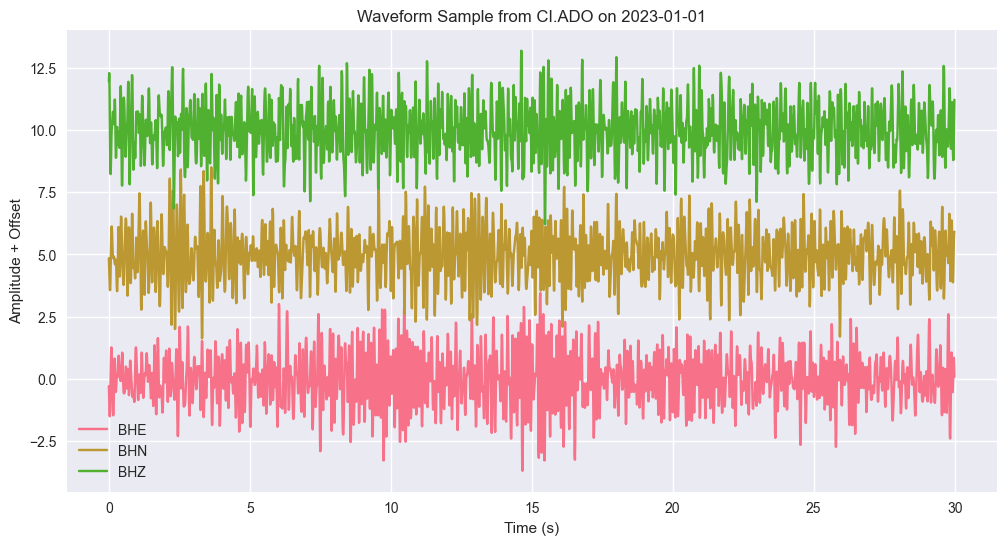

In [8]:
# pull data from the data set and plot the waveforms with obspy
sample = real_dataset[0]
waveform = sample['waveform'].numpy()
metadata = sample['metadata'].numpy()

plt.figure(figsize=(12, 6))
time_axis = np.arange(waveform.shape[1]) / real_dataset.sample_rate
for i in range(waveform.shape[0]):
    plt.plot(time_axis, waveform[i] + i * 5.0, label=sample['channels'][i])  # Offset for visibility
plt.title(f"Waveform Sample from {sample['station_id']} on {sample['date']}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude + Offset")    
plt.legend()

## 2.5. Load Pre-trained Wav2Vec2 Weights

Now we'll extract and load pre-trained Wav2Vec2 weights to initialize our GP2Vec model. This transfer learning approach leverages the powerful representations learned by Wav2Vec2 on speech data and adapts them for seismic signals.

In [21]:
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/12.0 MB ? eta -:--:--Requirement already satisfied: charset_normalizer<4,>=2 in /Users/marinedenolle/opt/miniconda3/envs/gp2vec/lib/python3.11/site-packages (from requests->transformers) (3.4.4)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 4.5 MB/s  0:00:02m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 4.5 MB/s  0:00:02m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 4.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 4.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 4.5 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 4.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 4.4 MB/s  0:00:00 eta 0:00:01━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/2.9 MB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 4.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [transformer

In [9]:
# Import Wav2Vec2 weight extractor
from gp2vec.utils.wav2vec_transfer import Wav2Vec2WeightExtractor

weights_dir = Path("../weights")
weights_dir.mkdir(exist_ok=True)
weights_path = weights_dir / "wav2vec2_base_weights.pth"

# Create extractor and save weights
extractor = Wav2Vec2WeightExtractor("facebook/wav2vec2-base-960h")
extractor.save_weights(str(weights_path))

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Extract and load pre-trained Wav2Vec2 weights
from pathlib import Path
import os

# First, let's extract the weights if they don't exist
weights_dir = Path("../weights")
weights_dir.mkdir(exist_ok=True)
weights_path = weights_dir / "wav2vec2_base_weights.pth"

if not weights_path.exists():
    print("🔧 Extracting Wav2Vec2 weights for the first time...")
    print("This will download the pre-trained model and extract adapted weights.")
    
    try:
        # Import the weight extraction utility
        from src.gp2vec.utils.wav2vec_transfer import Wav2Vec2WeightExtractor
        
        # Create extractor and save weights
        extractor = Wav2Vec2WeightExtractor("facebook/wav2vec2-base-960h")
        extractor.save_weights(str(weights_path))
        
        print(f"✅ Weights extracted and saved to {weights_path}")
        
    except ImportError as e:
        print(f"⚠️ Could not import transformers library: {e}")
        print("Install with: pip install transformers")
        print("Proceeding without pre-trained weights...")
        weights_path = None
        
    except Exception as e:
        print(f"⚠️ Error extracting weights: {e}")
        print("Proceeding without pre-trained weights...")
        weights_path = None
else:
    print(f"✅ Found existing Wav2Vec2 weights at {weights_path}")

# Load the weights info if available
if weights_path and weights_path.exists():
    try:
        import torch
        weights_info = torch.load(weights_path, map_location='cpu')
        
        print(f"\n📋 Wav2Vec2 Weight Information:")
        print(f"   - Source model: {weights_info['config']['model_name']}")
        print(f"   - Hidden size: {weights_info['config']['hidden_size']}")
        print(f"   - Transformer layers: {weights_info['config']['num_layers']}")
        print(f"   - Attention heads: {weights_info['config']['num_heads']}")
        print(f"   - File size: {weights_path.stat().st_size / (1024*1024):.1f} MB")
        
        for component in ['feature_encoder', 'transformer', 'quantizer']:
            if component in weights_info and isinstance(weights_info[component], dict):
                print(f"   - {component.replace('_', ' ').title()}: {len(weights_info[component])} parameters")
                
        wav2vec_available = True
        
    except Exception as e:
        print(f"⚠️ Error loading weight info: {e}")
        wav2vec_available = False
else:
    wav2vec_available = False
    print("⚠️ Wav2Vec2 weights not available - will use random initialization")

✅ Found existing Wav2Vec2 weights at ../weights/wav2vec2_base_weights.pth

📋 Wav2Vec2 Weight Information:
   - Source model: facebook/wav2vec2-base-960h
   - Hidden size: 768
   - Transformer layers: 12
   - Attention heads: 12
   - File size: 358.5 MB
   - Feature Encoder: 9 parameters
   - Transformer: 196 parameters
   - Quantizer: 0 parameters


### Visualize Sample Waveforms

Let's look at a few examples from our synthetic dataset to verify they look realistic.

Plotting samples from real_dataset with 10 total samples
s3://scedc-pds/continuous_waveforms/2023/2023_001/CIADO__BHE___2023001.ms
s3://scedc-pds/continuous_waveforms/2023/2023_001/CIADO__BHN___2023001.ms
s3://scedc-pds/continuous_waveforms/2023/2023_001/CIADO__BHN___2023001.ms
s3://scedc-pds/continuous_waveforms/2023/2023_001/CIADO__BHZ___2023001.ms
s3://scedc-pds/continuous_waveforms/2023/2023_001/CIADO__BHZ___2023001.ms
s3://scedc-pds/continuous_waveforms/2023/2023_001/CIADO__BHE___2023001.ms
s3://scedc-pds/continuous_waveforms/2023/2023_001/CIADO__BHE___2023001.ms
s3://scedc-pds/continuous_waveforms/2023/2023_001/CIADO__BHN___2023001.ms
s3://scedc-pds/continuous_waveforms/2023/2023_001/CIADO__BHN___2023001.ms
s3://scedc-pds/continuous_waveforms/2023/2023_001/CIADO__BHZ___2023001.ms
s3://scedc-pds/continuous_waveforms/2023/2023_001/CIADO__BHZ___2023001.ms
s3://scedc-pds/continuous_waveforms/2023/2023_001/CIADO__BHE___2023001.ms
s3://scedc-pds/continuous_waveforms/2023/2023_001/CIADO

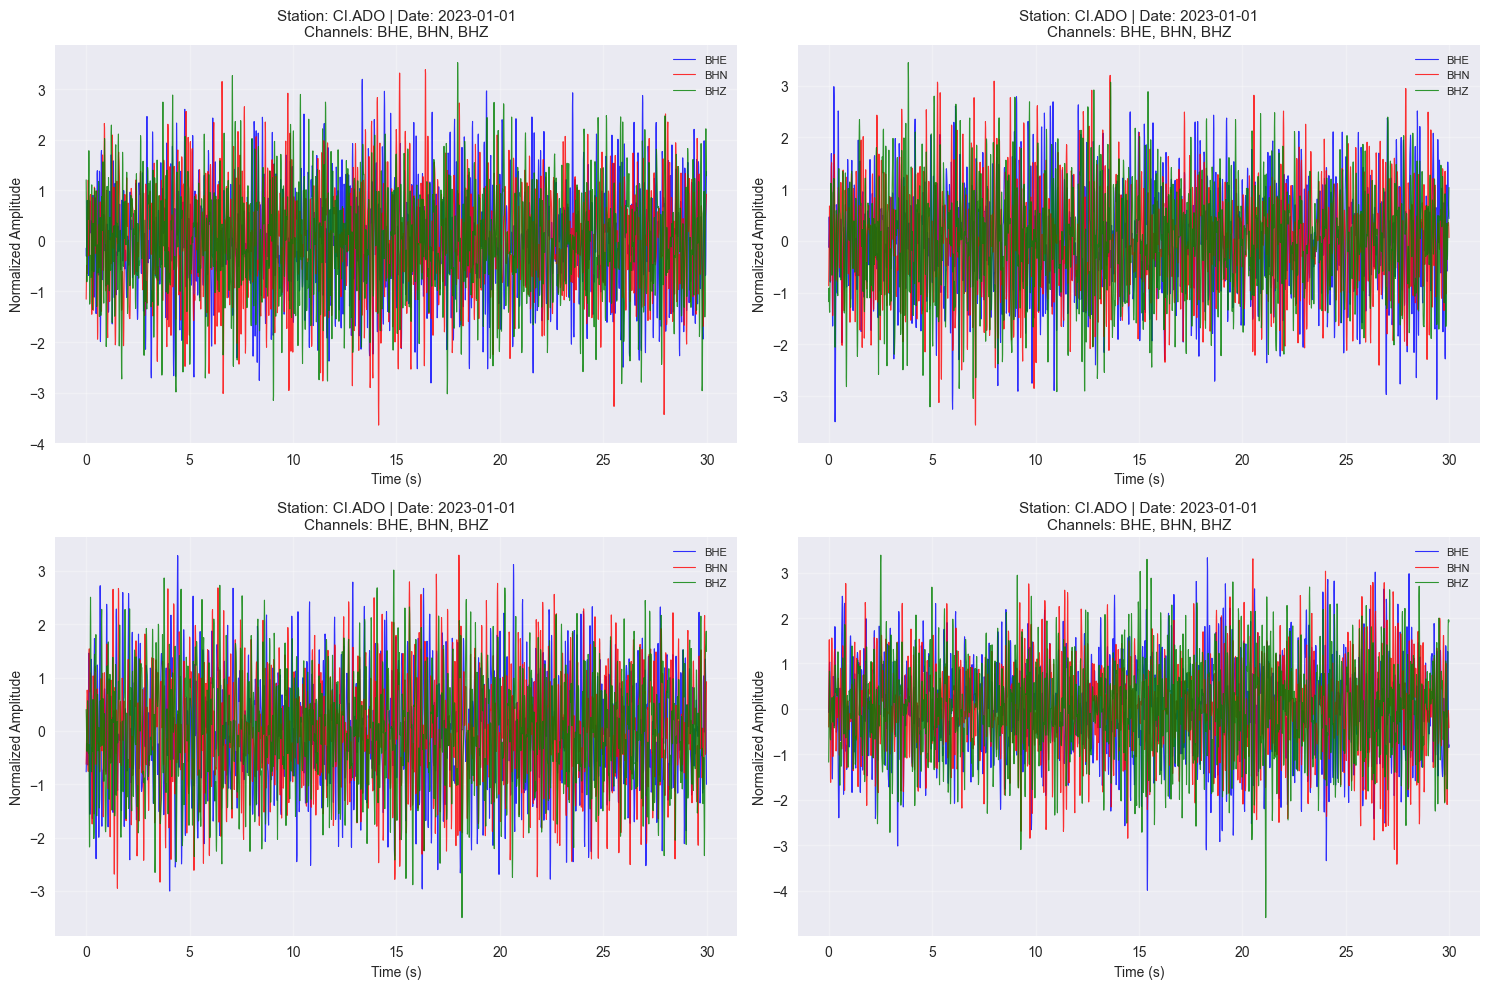


📈 Real Dataset Statistics:
   - Total samples available: 10
   - Station-days with data: 2
   - Samples per station-day: 5
   - Sample length: 30.0s @ 100.0Hz
   - Networks: ['CI']
   - Stations: ['ADO']
   - Channels: ['BHE', 'BHN', 'BHZ']

📍 Station Metadata:
   CI.ADO:
      Lat: 34.5505°, Lon: -117.4339°
      Elevation: 908.0m
      Site: Adelanto Receiving
s3://scedc-pds/continuous_waveforms/2023/2023_001/CIADO__BHE___2023001.ms
s3://scedc-pds/continuous_waveforms/2023/2023_001/CIADO__BHN___2023001.ms
s3://scedc-pds/continuous_waveforms/2023/2023_001/CIADO__BHN___2023001.ms
s3://scedc-pds/continuous_waveforms/2023/2023_001/CIADO__BHZ___2023001.ms
s3://scedc-pds/continuous_waveforms/2023/2023_001/CIADO__BHZ___2023001.ms
s3://scedc-pds/continuous_waveforms/2023/2023_002/CIADO__BHE___2023002.ms
s3://scedc-pds/continuous_waveforms/2023/2023_002/CIADO__BHE___2023002.ms
s3://scedc-pds/continuous_waveforms/2023/2023_002/CIADO__BHN___2023002.ms
s3://scedc-pds/continuous_waveforms/2023/2

In [ ]:
# Visualize some sample waveforms from real SCEDC data
print(f"Plotting samples from real_dataset with {len(real_dataset)} total samples")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

# Create time axis (30 seconds at 100 Hz = 3000 points)
time_axis = np.arange(real_dataset.sample_length_pts) / real_dataset.sample_rate

for i in range(min(4, len(real_dataset))):  # Plot up to 4 samples
    try:
        sample = real_dataset[i]
        waveform = sample['waveform'].numpy()
        metadata = sample['metadata'].numpy()
        station_id = sample['station_id']
        date = sample['date']
        channels = sample['channels']
        
        ax = axes[i]
        
        # Plot 3 components
        component_names = ['Z (Vertical)', 'N (North)', 'E (East)']
        colors = ['blue', 'red', 'green']
        
        for comp in range(3):
            label = f"{channels[comp]}" if comp < len(channels) else component_names[comp]
            ax.plot(time_axis, waveform[comp], 
                   color=colors[comp], alpha=0.8, 
                   label=label, linewidth=0.8)
        
        ax.set_xlabel('Time (s)', fontsize=10)
        ax.set_ylabel('Normalized Amplitude', fontsize=10)
        ax.set_title(f'Station: {station_id} | Date: {date}\n'
                    f'Channels: {", ".join(channels)}', fontsize=11)
        ax.legend(loc='upper right', fontsize=8)
        ax.grid(True, alpha=0.3)
        
    except Exception as e:
        print(f"Could not plot sample {i}: {e}")
        continue

plt.tight_layout()
plt.show()

# Print dataset statistics
print(f"\n📈 Real Dataset Statistics:")
print(f"   - Total samples available: {len(real_dataset)}")
print(f"   - Station-days with data: {len(real_dataset.file_list)}")
print(f"   - Samples per station-day: {real_dataset.samples_per_day}")
print(f"   - Sample length: {real_dataset.sample_length_sec}s @ {real_dataset.sample_rate}Hz")
print(f"   - Networks: {real_dataset.networks}")
print(f"   - Stations: {real_dataset.stations}")
print(f"   - Channels: {real_dataset.channels}")

# Show metadata from loaded samples
print(f"\n📍 Station Metadata:")
for station_key, meta in list(real_dataset.station_metadata.items())[:5]:
    print(f"   {station_key}:")
    print(f"      Lat: {meta['latitude']:.4f}°, Lon: {meta['longitude']:.4f}°")
    print(f"      Elevation: {meta['elevation']:.1f}m")
    print(f"      Site: {meta['site_name']}")

# Visualize waveform characteristics
if len(real_dataset) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    
    # Sample a few waveforms to check amplitude distribution
    sample_indices = np.random.choice(min(len(real_dataset), 20), 
                                     size=min(len(real_dataset), 10), 
                                     replace=False)
    amplitudes = []
    
    for idx in sample_indices:
        try:
            sample = real_dataset[int(idx)]
            amplitudes.extend(sample['waveform'].numpy().flatten())
        except:
            continue
    
    if amplitudes:
        # Amplitude distribution
        axes[0].hist(amplitudes, bins=50, alpha=0.7, color='skyblue', density=True)
        axes[0].set_xlabel('Normalized Amplitude')
        axes[0].set_ylabel('Density')
        axes[0].set_title('Waveform Amplitude Distribution (Normalized)')
        axes[0].grid(True, alpha=0.3)
        
        # Sample power spectrum
        sample = real_dataset[0]
        waveform = sample['waveform'].numpy()[0]  # First component
        freqs = np.fft.fftfreq(len(waveform), 1/real_dataset.sample_rate)
        fft = np.abs(np.fft.fft(waveform))
        
        # Plot only positive frequencies
        pos_mask = freqs > 0
        axes[1].semilogy(freqs[pos_mask], fft[pos_mask], alpha=0.8, color='coral')
        axes[1].set_xlabel('Frequency (Hz)')
        axes[1].set_ylabel('Power Spectrum')
        axes[1].set_title('Sample Power Spectrum (First Component)')
        axes[1].grid(True, alpha=0.3, which='both')
        axes[1].set_xlim(0, 50)  # Show up to 50 Hz
        
        plt.tight_layout()
        plt.show()

## 3. Data Preprocessing and Splitting

Now we'll prepare the data for training by:
1. Creating train/validation splits
2. Setting up data loaders with small batch sizes
3. Implementing data preprocessing utilities

In [ ]:
def collate_fn(batch):
    """
    Custom collate function for seismic data batches.
    """
    # Stack waveforms
    waveforms = torch.stack([item['waveform'] for item in batch])
    
    # Collect metadata
    metadata = {}
    for key in ['latitude', 'longitude', 'elevation']:
        metadata[key] = torch.stack([item['metadata'][key] for item in batch])
    
    # Collect instruments (categorical)
    instruments = [item['metadata']['instrument'] for item in batch]
    
    # Collect labels
    labels = {}
    for key in batch[0]['labels'].keys():
        if key == 'has_event':
            labels[key] = torch.tensor([item['labels'][key] for item in batch])
        else:
            # Only collect numeric labels for samples that have events
            values = []
            for item in batch:
                if item['labels']['has_event'] and key in item['labels']:
                    values.append(item['labels'][key])
                else:
                    values.append(0.0)  # Default value for non-events
            labels[key] = torch.tensor(values)
    
    # Collect indices
    indices = torch.tensor([item['idx'] for item in batch])
    
    return {
        'waveform': waveforms,
        'metadata': metadata,
        'instruments': instruments,
        'labels': labels,
        'indices': indices
    }

# Split dataset into train/validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Use random split for simplicity (in practice, might use temporal or spatial splits)
train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size], 
    generator=torch.Generator().manual_seed(42)
)

print(f"📊 Data split:")
print(f"   - Training samples: {len(train_dataset)}")
print(f"   - Validation samples: {len(val_dataset)}")

# Create data loaders with small batch sizes for prototyping
batch_size = 8  # Small batch for rapid iteration
num_workers = 2  # Reduced for notebook

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    collate_fn=collate_fn,
    pin_memory=torch.cuda.is_available(),
    persistent_workers=True if num_workers > 0 else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    collate_fn=collate_fn,
    pin_memory=torch.cuda.is_available(),
    persistent_workers=True if num_workers > 0 else False
)

print(f"🔄 Data loaders created:")
print(f"   - Batch size: {batch_size}")
print(f"   - Train batches: {len(train_loader)}")
print(f"   - Val batches: {len(val_loader)}")

# Test the data loader
print("\n🧪 Testing data loader...")
sample_batch = next(iter(train_loader))
print(f"   - Waveform batch shape: {sample_batch['waveform'].shape}")
print(f"   - Metadata keys: {list(sample_batch['metadata'].keys())}")
print(f"   - Labels keys: {list(sample_batch['labels'].keys())}")
print(f"   - Has event distribution: {sample_batch['labels']['has_event'].sum().item()}/{len(sample_batch['labels']['has_event'])} samples")

## 4. Define Simplified GP2Vec Architecture

We'll create a simplified version of the GP2Vec model suitable for prototyping. This includes:
- **Feature Encoder**: Simplified CNN
- **Vector Quantizer**: Basic Gumbel-based quantization
- **Context Encoder**: Small Transformer
- **Contrastive Loss**: InfoNCE implementation

In [ ]:
# Create the GP2Vec model with optional Wav2Vec2 initialization
print("🔧 Creating GP2Vec model...")

# Use production GP2Vec if available, otherwise use simplified version
try:
    from src.gp2vec.models.gp2vec import create_gp2vec_model
    
    # Create full GP2Vec model
    model = create_gp2vec_model(
        model_size="base",  # Use base size for prototype
        input_channels=3,
        # metadata_config={
        #     'categorical_features': {},
        #     'continuous_features': ['latitude', 'longitude', 'elevation']
        # }
    )
    
    print(f"✅ Created production GP2Vec model with {sum(p.numel() for p in model.parameters()):,} parameters")
    
    # Load Wav2Vec2 weights if available
    if wav2vec_available and weights_path and weights_path.exists():
        print("🔄 Initializing with pre-trained Wav2Vec2 weights...")
        try:
            stats = model.load_wav2vec_weights(weights_path, strict=False, verbose=True)
            print(f"✅ Transferred {stats['updated_params']} parameters ({stats['update_ratio']:.1%} of model)")
        except Exception as e:
            print(f"⚠️ Could not load Wav2Vec2 weights: {e}")
            print("Proceeding with random initialization...")
    else:
        print("ℹ️ Using random weight initialization")
        
    using_production_model = True
    
except ImportError:
    print("⚠️ Production GP2Vec not available, using simplified version...")
    using_production_model = False
    
    # Fallback to simplified model (as defined earlier in notebook)
    class SimpleFeatureEncoder(nn.Module):
        """Simplified CNN feature encoder for prototyping."""
        
        def __init__(self, input_channels=3, embed_dim=256):
            super().__init__()
            
            self.layers = nn.ModuleList([
                # Layer 1: (3, 3000) -> (64, 600)  
                nn.Conv1d(input_channels, 64, kernel_size=10, stride=5),
                nn.BatchNorm1d(64),
                nn.GELU(),
                
                # Layer 2: (64, 600) -> (128, 150)
                nn.Conv1d(64, 128, kernel_size=8, stride=4),
                nn.BatchNorm1d(128), 
                nn.GELU(),
                
                # Layer 3: (128, 150) -> (256, 75)
                nn.Conv1d(128, embed_dim, kernel_size=4, stride=2),
                nn.BatchNorm1d(embed_dim),
                nn.GELU(),
            ])
            
            self.embed_dim = embed_dim
            
        def forward(self, x):
            """Forward pass through CNN layers."""
            # x: (batch, channels, time)
            for i, layer in enumerate(self.layers):
                x = layer(x)
            
            # Transpose to (batch, time, embed_dim)
            return x.transpose(1, 2)

    class SimpleVectorQuantizer(nn.Module):
        """Simplified Gumbel vector quantizer."""
        
        def __init__(self, embed_dim=256, codebook_size=128, temperature=2.0):
            super().__init__()
            
            self.embed_dim = embed_dim
            self.codebook_size = codebook_size
            self.temperature = temperature
            
            # Learnable codebook
            self.codebook = nn.Parameter(torch.randn(codebook_size, embed_dim))
            
            # Projection layer
            self.project = nn.Linear(embed_dim, codebook_size)
            
        def forward(self, x):
            """Quantize input features."""
            # x: (batch, time, embed_dim)
            batch_size, seq_len, embed_dim = x.shape
            
            # Flatten for processing
            x_flat = x.view(-1, embed_dim)  # (batch*time, embed_dim)
            
            # Compute logits
            logits = self.project(x_flat)  # (batch*time, codebook_size)
            
            # Gumbel softmax
            if self.training:
                # Add Gumbel noise
                gumbel_noise = -torch.log(-torch.log(torch.rand_like(logits) + 1e-8) + 1e-8)
                soft_codes = F.softmax((logits + gumbel_noise) / self.temperature, dim=-1)
            else:
                soft_codes = F.softmax(logits / self.temperature, dim=-1)
            
            # Get quantized features
            quantized = torch.matmul(soft_codes, self.codebook)  # (batch*time, embed_dim)
            
            # Reshape back
            quantized = quantized.view(batch_size, seq_len, embed_dim)
            
            # Compute perplexity (measure of codebook usage)
            avg_probs = soft_codes.mean(dim=0)
            perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-8)))
            
            return quantized, 0.0, perplexity  # No VQ loss for Gumbel

    class SimpleTransformer(nn.Module):
        """Simplified Transformer for context encoding."""
        
        def __init__(self, embed_dim=256, num_heads=8, num_layers=4, dropout=0.1):
            super().__init__()
            
            self.embed_dim = embed_dim
            
            # Positional encoding
            self.pos_encoding = nn.Parameter(torch.randn(1000, embed_dim) * 0.02)
            
            # Transformer layers
            encoder_layer = nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dim_feedforward=embed_dim * 4,
                dropout=dropout,
                activation='gelu',
                batch_first=True
            )
            self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
            
            # Layer norm
            self.layer_norm = nn.LayerNorm(embed_dim)
            
        def forward(self, x, mask=None):
            """Forward pass through transformer."""
            # x: (batch, time, embed_dim)
            batch_size, seq_len, embed_dim = x.shape
            
            # Add positional encoding
            pos_enc = self.pos_encoding[:seq_len].unsqueeze(0).expand(batch_size, -1, -1)
            x = x + pos_enc
            
            # Apply transformer
            x = self.transformer(x, src_key_padding_mask=mask)
            
            # Layer norm
            x = self.layer_norm(x)
            
            return x

    class SimpleMetadataEncoder(nn.Module):
        """Simple metadata encoder."""
        
        def __init__(self, embed_dim=256):
            super().__init__()
            
            # Coordinate embedding (lat, lon, elevation)
            self.coord_proj = nn.Linear(3, embed_dim // 2)
            
            # Simple fusion
            self.fusion = nn.Linear(embed_dim + embed_dim // 2, embed_dim)
            self.dropout = nn.Dropout(0.1)
            
        def forward(self, features, metadata):
            """Fuse features with metadata."""
            # features: (batch, time, embed_dim)
            # metadata: dict with lat, lon, elevation tensors
            
            # Stack coordinates
            coords = torch.stack([
                metadata['latitude'],
                metadata['longitude'], 
                metadata['elevation'] / 1000.0  # Scale elevation
            ], dim=1)  # (batch, 3)
            
            # Project coordinates
            coord_embed = self.coord_proj(coords)  # (batch, embed_dim//2)
            
            # Expand to sequence length
            batch_size, seq_len, embed_dim = features.shape
            coord_embed = coord_embed.unsqueeze(1).expand(-1, seq_len, -1)
            
            # Concatenate and fuse
            fused = torch.cat([features, coord_embed], dim=-1)
            fused = self.fusion(fused)
            fused = self.dropout(fused)
            
            return fused

    class SimpleContrastiveLoss(nn.Module):
        """Simplified contrastive loss for self-supervised learning."""
        
        def __init__(self, temperature=0.1, mask_prob=0.15):
            super().__init__()
            self.temperature = temperature
            self.mask_prob = mask_prob
            
        def create_mask(self, seq_len, batch_size):
            """Create random mask for contrastive learning."""
            mask = torch.rand(batch_size, seq_len) < self.mask_prob
            return mask
            
        def forward(self, features, quantized_features):
            """Compute contrastive loss."""
            # features: (batch, time, embed_dim) - context features
            # quantized_features: (batch, time, embed_dim) - quantized features
            
            batch_size, seq_len, embed_dim = features.shape
            device = features.device
            
            # Create mask
            mask = self.create_mask(seq_len, batch_size).to(device)
            
            if not mask.any():
                return torch.tensor(0.0, device=device)
            
            # Get masked positions
            masked_features = features[mask]  # (num_masked, embed_dim)
            target_quantized = quantized_features[mask]  # (num_masked, embed_dim)
            
            if len(masked_features) == 0:
                return torch.tensor(0.0, device=device)
            
            # Normalize features
            masked_features = F.normalize(masked_features, dim=-1)
            target_quantized = F.normalize(target_quantized, dim=-1)
            
            # Compute similarities
            logits = torch.matmul(masked_features, target_quantized.t()) / self.temperature
            
            # Targets (diagonal should be positive pairs)
            targets = torch.arange(len(masked_features), device=device)
            
            # Cross entropy loss
            loss = F.cross_entropy(logits, targets)
            
            return loss

    class SimpleGP2Vec(pl.LightningModule):
        """Simplified GP2Vec model for prototyping."""
        
        def __init__(self, 
                     input_channels=3,
                     embed_dim=256, 
                     codebook_size=128,
                     num_heads=8,
                     num_layers=4,
                     learning_rate=1e-3,
                     temperature=0.1,
                     use_metadata=True):
            super().__init__()
            
            self.save_hyperparameters()
            
            # Model components
            self.feature_encoder = SimpleFeatureEncoder(input_channels, embed_dim)
            self.quantizer = SimpleVectorQuantizer(embed_dim, codebook_size)
            self.context_encoder = SimpleTransformer(embed_dim, num_heads, num_layers)
            
            if use_metadata:
                self.metadata_encoder = SimpleMetadataEncoder(embed_dim)
            else:
                self.metadata_encoder = None
                
            self.contrastive_loss = SimpleContrastiveLoss(temperature)
            
            # Metrics tracking
            self.train_losses = []
            self.val_losses = []
            
        def forward(self, waveforms, metadata=None):
            """Forward pass."""
            # Encode features
            features = self.feature_encoder(waveforms)  # (batch, time, embed_dim)
            
            # Quantize
            quantized, vq_loss, perplexity = self.quantizer(features)
            
            # Add metadata if available
            if self.metadata_encoder is not None and metadata is not None:
                quantized = self.metadata_encoder(quantized, metadata)
            
            # Context encoding
            context_features = self.context_encoder(quantized)
            
            return {
                'features': features,
                'quantized': quantized,
                'context_features': context_features,
                'vq_loss': vq_loss,
                'perplexity': perplexity
            }
        
        def training_step(self, batch, batch_idx):
            """Training step."""
            waveforms = batch['waveform']
            metadata = batch['metadata'] if self.metadata_encoder else None
            
            # Forward pass
            outputs = self(waveforms, metadata)
            
            # Compute losses
            contrastive_loss = self.contrastive_loss(
                outputs['context_features'], 
                outputs['quantized']
            )
            
            total_loss = contrastive_loss + outputs['vq_loss']
            
            # Logging
            self.log('train/contrastive_loss', contrastive_loss, prog_bar=True)
            self.log('train/vq_loss', outputs['vq_loss'])
            self.log('train/total_loss', total_loss)
            self.log('train/perplexity', outputs['perplexity'], prog_bar=True)
            
            return total_loss
        
        def validation_step(self, batch, batch_idx):
            """Validation step."""
            waveforms = batch['waveform']
            metadata = batch['metadata'] if self.metadata_encoder else None
            
            # Forward pass
            outputs = self(waveforms, metadata)
            
            # Compute losses
            contrastive_loss = self.contrastive_loss(
                outputs['context_features'],
                outputs['quantized']
            )
            
            total_loss = contrastive_loss + outputs['vq_loss']
            
            # Logging
            self.log('val/contrastive_loss', contrastive_loss, prog_bar=True)
            self.log('val/vq_loss', outputs['vq_loss'])
            self.log('val/total_loss', total_loss)
            self.log('val/perplexity', outputs['perplexity'], prog_bar=True)
            
            return total_loss
        
        def configure_optimizers(self):
            """Configure optimizer."""
            optimizer = torch.optim.AdamW(
                self.parameters(), 
                lr=self.hparams.learning_rate,
                weight_decay=0.01
            )
            
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer, T_max=100, eta_min=1e-6
            )
            
            return {
                'optimizer': optimizer,
                'lr_scheduler': scheduler,
                'monitor': 'val/total_loss'
            }
        
        def encode(self, waveforms, metadata=None):
            """Extract features for downstream tasks."""
            self.eval()
            with torch.no_grad():
                outputs = self(waveforms, metadata)
                return outputs['context_features']

    # Create the simplified model
    model = SimpleGP2Vec(
        input_channels=3,
        embed_dim=256,  # Smaller for prototyping
        codebook_size=64,  # Smaller codebook
        num_heads=8,
        num_layers=4,  # Fewer layers
        learning_rate=1e-3,
        use_metadata=True
    )
    
    print(f"✅ Created simplified GP2Vec model with {sum(p.numel() for p in model.parameters()):,} parameters")

print(f"\n🔧 Model Summary:")
print(f"   - Architecture: {'Production' if using_production_model else 'Simplified'} GP2Vec")
print(f"   - Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   - Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"   - Model size: {sum(p.numel() * 4 for p in model.parameters()) / 1024**2:.2f} MB")
print(f"   - Pre-trained init: {'✓ Wav2Vec2' if wav2vec_available and using_production_model else '✗ Random'}")

# Test forward pass
print("\n🧪 Testing forward pass...")
try:
    sample_batch = next(iter(train_loader))
    
    if using_production_model:
        # Production model expects different input format
        waveforms = sample_batch['waveform']
        metadata = {
            'latitude': sample_batch['metadata'][:, 0],
            'longitude': sample_batch['metadata'][:, 1], 
            'elevation': sample_batch['metadata'][:, 2]
        } if 'metadata' in sample_batch else None
        
        outputs = model.forward(waveforms, metadata)
    else:
        # Simplified model
        outputs = model(sample_batch['waveform'], sample_batch.get('metadata'))

    print(f"   ✅ Forward pass successful!")
    print(f"   - Input shape: {sample_batch['waveform'].shape}")
    
    if isinstance(outputs, dict):
        for key, value in outputs.items():
            if isinstance(value, torch.Tensor):
                print(f"   - {key} shape: {value.shape}")
            else:
                print(f"   - {key}: {value}")
    
except Exception as e:
    print(f"   ❌ Forward pass failed: {e}")
    import traceback
    traceback.print_exc()

## 5. Configure Training Parameters

Set up training parameters optimized for rapid prototyping with small batches and short training runs.

In [ ]:
# Create data loaders with real SCEDC data (or fallback synthetic)
print("Creating data loaders...")

# Use the real_dataset created above
train_size = int(0.8 * len(real_dataset))
val_size = len(real_dataset) - train_size

# Split dataset
train_dataset, val_dataset = torch.utils.data.random_split(
    real_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Create data loaders with small batch size for prototyping
train_loader = DataLoader(
    train_dataset,
    batch_size=4,  # Small batch size
    shuffle=True,
    num_workers=0,  # Avoid multiprocessing issues with S3
    pin_memory=torch.cuda.is_available()
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    pin_memory=torch.cuda.is_available()
)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

# Test loading a batch
print("\nTesting batch loading...")
try:
    sample_batch = next(iter(train_loader))
    print(f"Batch waveform shape: {sample_batch['waveform'].shape}")
    print(f"Batch metadata shape: {sample_batch['metadata'].shape}")
    print(f"Station IDs: {sample_batch['station_id'][:2]}...")  # Show first 2
    print("✓ Data loaders created successfully!")
except Exception as e:
    print(f"❌ Error in batch loading: {e}")
    print("This might happen with S3 connectivity - the training loop will handle retries.")

## 6. Implement Training Loop with Small Batches

Now we'll train the model using PyTorch Lightning with our small batch configuration.

In [ ]:
# Create trainer
trainer = Trainer(
    **training_config,
    callbacks=callbacks,
    logger=csv_logger,
    accelerator='auto',  # Use GPU if available
    devices='auto',
    precision='16-mixed' if torch.cuda.is_available() else '32-true',
    enable_progress_bar=True,
    enable_model_summary=True,
    deterministic=False,  # Set to True for reproducibility (slower)
)

print("🚀 Starting training...")
print(f"   - Device: {trainer.strategy.root_device}")
print(f"   - Precision: {trainer.precision}")
print(f"   - Accelerator: {trainer.accelerator}")

# Train the model
start_time = pd.Timestamp.now()

try:
    trainer.fit(
        model=model,
        train_dataloaders=train_loader,
        val_dataloaders=val_loader
    )
    
    end_time = pd.Timestamp.now()
    training_duration = end_time - start_time
    
    print(f"\n✅ Training completed successfully!")
    print(f"   - Duration: {training_duration}")
    print(f"   - Final epoch: {trainer.current_epoch}")
    print(f"   - Best validation loss: {checkpoint_callback.best_model_score:.4f}")
    
except KeyboardInterrupt:
    print("\n⚠️ Training interrupted by user")
    end_time = pd.Timestamp.now()
    training_duration = end_time - start_time
    print(f"   - Partial training duration: {training_duration}")
    
except Exception as e:
    print(f"\n❌ Training failed: {e}")
    import traceback
    traceback.print_exc()

## 7. Monitor Training Progress

Let's analyze the training progress and visualize the learning curves.

In [ ]:
# Load training metrics from CSV logger
try:
    metrics_df = pd.read_csv('./gp2vec_logs/version_0/metrics.csv')
    
    print("📊 Training Metrics Summary:")
    print(f"   - Total logged steps: {len(metrics_df)}")
    print(f"   - Columns: {list(metrics_df.columns)}")
    
    # Clean and prepare metrics
    # Drop NaN values and separate train/val metrics
    train_metrics = metrics_df.dropna(subset=['train/total_loss'])
    val_metrics = metrics_df.dropna(subset=['val/total_loss'])
    
    print(f"   - Training steps: {len(train_metrics)}")
    print(f"   - Validation steps: {len(val_metrics)}")
    
    # Plot training curves
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss curves
    axes[0, 0].plot(train_metrics['step'], train_metrics['train/total_loss'], 
                   label='Train Loss', alpha=0.8, linewidth=2)
    if len(val_metrics) > 0:
        axes[0, 0].plot(val_metrics['step'], val_metrics['val/total_loss'], 
                       label='Val Loss', alpha=0.8, linewidth=2)
    axes[0, 0].set_xlabel('Step')
    axes[0, 0].set_ylabel('Total Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Contrastive loss
    axes[0, 1].plot(train_metrics['step'], train_metrics['train/contrastive_loss'],
                   label='Train Contrastive', alpha=0.8)
    if len(val_metrics) > 0 and 'val/contrastive_loss' in val_metrics.columns:
        axes[0, 1].plot(val_metrics['step'], val_metrics['val/contrastive_loss'],
                       label='Val Contrastive', alpha=0.8)
    axes[0, 1].set_xlabel('Step')
    axes[0, 1].set_ylabel('Contrastive Loss')
    axes[0, 1].set_title('Contrastive Loss (InfoNCE)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Perplexity (codebook usage)
    axes[1, 0].plot(train_metrics['step'], train_metrics['train/perplexity'],
                   label='Train Perplexity', alpha=0.8)
    if len(val_metrics) > 0 and 'val/perplexity' in val_metrics.columns:
        axes[1, 0].plot(val_metrics['step'], val_metrics['val/perplexity'],
                       label='Val Perplexity', alpha=0.8)
    axes[1, 0].set_xlabel('Step')
    axes[1, 0].set_ylabel('Perplexity')
    axes[1, 0].set_title('Codebook Perplexity (Usage Diversity)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Learning rate (if available)
    if 'lr-AdamW' in train_metrics.columns:
        axes[1, 1].plot(train_metrics['step'], train_metrics['lr-AdamW'],
                       label='Learning Rate', alpha=0.8, color='green')
        axes[1, 1].set_xlabel('Step')
        axes[1, 1].set_ylabel('Learning Rate')
        axes[1, 1].set_title('Learning Rate Schedule')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    else:
        # Plot VQ loss instead
        if 'train/vq_loss' in train_metrics.columns:
            axes[1, 1].plot(train_metrics['step'], train_metrics['train/vq_loss'],
                           label='Train VQ Loss', alpha=0.8)
            if len(val_metrics) > 0 and 'val/vq_loss' in val_metrics.columns:
                axes[1, 1].plot(val_metrics['step'], val_metrics['val/vq_loss'],
                               label='Val VQ Loss', alpha=0.8)
            axes[1, 1].set_xlabel('Step')
            axes[1, 1].set_ylabel('VQ Loss')
            axes[1, 1].set_title('Vector Quantization Loss')
            axes[1, 1].legend()
            axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    if len(val_metrics) > 0:
        final_val_loss = val_metrics['val/total_loss'].iloc[-1]
        final_val_perplexity = val_metrics['val/perplexity'].iloc[-1]
        print(f"\n📈 Final Metrics:")
        print(f"   - Final validation loss: {final_val_loss:.4f}")
        print(f"   - Final validation perplexity: {final_val_perplexity:.2f}")
        print(f"   - Codebook utilization: {final_val_perplexity/model.hparams.codebook_size:.1%}")
        
except FileNotFoundError:
    print("⚠️ No training metrics found. Make sure training completed successfully.")
except Exception as e:
    print(f"❌ Error loading metrics: {e}")
    
# Display model summary
print(f"\n🔧 Model Architecture Summary:")
print(f"   - Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   - Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"   - Model size (MB): {sum(p.numel() * 4 for p in model.parameters()) / 1024**2:.2f}")

# Memory usage (if CUDA)
if torch.cuda.is_available():
    print(f"   - GPU memory allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"   - GPU memory reserved: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

## 8. Evaluate Model Performance

Now let's evaluate the learned representations by testing feature extraction and analyzing the model's behavior.

In [ ]:
# Load best model from checkpoint
if os.path.exists('./checkpoints'):
    checkpoint_files = [f for f in os.listdir('./checkpoints') if f.endswith('.ckpt')]
    if checkpoint_files:
        best_checkpoint = max(checkpoint_files, key=lambda x: os.path.getctime(os.path.join('./checkpoints', x)))
        best_model_path = os.path.join('./checkpoints', best_checkpoint)
        
        print(f"📂 Loading best model from: {best_checkpoint}")
        best_model = SimpleGP2Vec.load_from_checkpoint(best_model_path)
        best_model.eval()
    else:
        print("⚠️ No checkpoints found, using current model")
        best_model = model
        best_model.eval()
else:
    print("⚠️ No checkpoint directory found, using current model")
    best_model = model
    best_model.eval()

# Feature extraction evaluation
print("\n🔍 Evaluating feature extraction...")

# Extract features from validation set
all_features = []
all_labels = []
all_waveforms = []

with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(val_loader, desc="Extracting features")):
        if batch_idx >= 10:  # Limit to 10 batches for prototype
            break
            
        waveforms = batch['waveform']
        metadata = batch['metadata']
        labels = batch['labels']
        
        # Extract features
        features = best_model.encode(waveforms, metadata)  # (batch, time, embed_dim)
        
        # Pool features (mean pooling across time)
        pooled_features = features.mean(dim=1)  # (batch, embed_dim)
        
        all_features.append(pooled_features.cpu())
        all_labels.append(labels['has_event'].cpu())
        all_waveforms.append(waveforms.cpu())

if all_features:
    all_features = torch.cat(all_features, dim=0)  # (N, embed_dim)
    all_labels = torch.cat(all_labels, dim=0)      # (N,)
    all_waveforms = torch.cat(all_waveforms, dim=0) # (N, 3, seq_len)
    
    print(f"✅ Extracted features from {len(all_features)} samples")
    print(f"   - Feature dimensions: {all_features.shape}")
    print(f"   - Event samples: {all_labels.sum().item()}/{len(all_labels)} ({100*all_labels.float().mean():.1f}%)")
    
    # Dimensionality reduction for visualization
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    
    # PCA
    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(all_features.numpy())
    
    print(f"   - PCA explained variance: {pca.explained_variance_ratio_.sum():.3f}")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # PCA plot
    scatter = axes[0].scatter(features_pca[:, 0], features_pca[:, 1], 
                             c=all_labels.numpy(), cmap='RdYlBu', alpha=0.7, s=20)
    axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.3f})')
    axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.3f})')
    axes[0].set_title('Feature Space Visualization (PCA)')
    axes[0].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[0], label='Has Event')
    
    # Feature magnitude distribution
    feature_norms = torch.norm(all_features, dim=1).numpy()
    axes[1].hist(feature_norms[all_labels.numpy() == 0], alpha=0.7, label='Noise', bins=20, density=True)
    axes[1].hist(feature_norms[all_labels.numpy() == 1], alpha=0.7, label='Event', bins=20, density=True)
    axes[1].set_xlabel('Feature L2 Norm')
    axes[1].set_ylabel('Density')
    axes[1].set_title('Feature Magnitude Distribution')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Simple linear probe evaluation
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score, classification_report
    from sklearn.model_selection import train_test_split
    
    print("\n🎯 Simple downstream evaluation (Linear Probe):")
    
    # Split features for evaluation
    X_train, X_test, y_train, y_test = train_test_split(
        all_features.numpy(), all_labels.numpy(), 
        test_size=0.3, random_state=42, stratify=all_labels.numpy()
    )
    
    # Train linear classifier
    clf = LogisticRegression(random_state=42, max_iter=1000)
    clf.fit(X_train, y_train)
    
    # Evaluate
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"   - Linear probe accuracy: {accuracy:.3f}")
    print(f"   - Classification report:")
    print(classification_report(y_test, y_pred, target_names=['Noise', 'Event'], zero_division=0))
    
else:
    print("❌ No features extracted. Check validation data loading.")

## 9. Visualize Training Metrics and Model Analysis

Let's create comprehensive visualizations to understand how well our GP2Vec model learned.

In [ ]:
# Analyze model components and learned representations
print("🔬 Model Analysis and Visualization")

# 1. Codebook analysis
with torch.no_grad():
    sample_batch = next(iter(val_loader))
    waveforms = sample_batch['waveform'][:4]  # Take 4 samples
    metadata = {k: v[:4] for k, v in sample_batch['metadata'].items()}
    
    # Forward pass to get intermediate outputs
    outputs = best_model(waveforms, metadata)
    
    print(f"\n📊 Model Component Analysis:")
    print(f"   - Input waveforms: {waveforms.shape}")
    print(f"   - CNN features: {outputs['features'].shape}")
    print(f"   - Quantized features: {outputs['quantized'].shape}")
    print(f"   - Context features: {outputs['context_features'].shape}")
    print(f"   - Codebook perplexity: {outputs['perplexity']:.2f}")

# 2. Attention pattern visualization (if applicable)
# For this simplified model, we'll visualize feature evolution through layers

fig = plt.figure(figsize=(20, 12))

# Create a 2x3 grid for different visualizations
gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

# 2.1 Input waveforms
ax1 = fig.add_subplot(gs[0, :2])
time_axis = np.arange(waveforms.shape[-1]) / 100  # 100 Hz sampling
for i in range(min(3, waveforms.shape[0])):
    for comp in range(3):
        ax1.plot(time_axis, waveforms[i, comp].cpu().numpy() + i*2, 
                alpha=0.8, linewidth=0.8, 
                label=f'Sample {i+1}, Comp {["Z","N","E"][comp]}' if i == 0 else "")
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude (offset)')
ax1.set_title('Input Waveforms (First 3 Samples)')
if waveforms.shape[0] > 0:
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# 2.2 CNN feature maps
ax2 = fig.add_subplot(gs[0, 2:])
cnn_features = outputs['features'][0].cpu().numpy()  # First sample (time, channels)
im1 = ax2.imshow(cnn_features.T, aspect='auto', cmap='RdBu_r', interpolation='nearest')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Feature Channels')
ax2.set_title('CNN Feature Maps (Sample 1)')
plt.colorbar(im1, ax=ax2, shrink=0.8)

# 2.3 Quantized features
ax3 = fig.add_subplot(gs[1, :2])
quant_features = outputs['quantized'][0].cpu().numpy()  # First sample
im2 = ax3.imshow(quant_features.T, aspect='auto', cmap='viridis', interpolation='nearest')
ax3.set_xlabel('Time Steps') 
ax3.set_ylabel('Quantized Channels')
ax3.set_title('Quantized Features (Sample 1)')
plt.colorbar(im2, ax=ax3, shrink=0.8)

# 2.4 Context features (Transformer output)
ax4 = fig.add_subplot(gs[1, 2:])
context_features = outputs['context_features'][0].cpu().numpy()  # First sample
im3 = ax4.imshow(context_features.T, aspect='auto', cmap='plasma', interpolation='nearest')
ax4.set_xlabel('Time Steps')
ax4.set_ylabel('Context Channels')
ax4.set_title('Context Features (Sample 1)')
plt.colorbar(im3, ax=ax4, shrink=0.8)

# 2.5 Feature evolution comparison
ax5 = fig.add_subplot(gs[2, :2])
# Compare feature norms across processing stages
cnn_norms = torch.norm(outputs['features'], dim=-1)[0].cpu().numpy()
quant_norms = torch.norm(outputs['quantized'], dim=-1)[0].cpu().numpy()  
context_norms = torch.norm(outputs['context_features'], dim=-1)[0].cpu().numpy()

time_steps = np.arange(len(cnn_norms))
ax5.plot(time_steps, cnn_norms, label='CNN Features', alpha=0.8, linewidth=2)
ax5.plot(time_steps, quant_norms, label='Quantized Features', alpha=0.8, linewidth=2)
ax5.plot(time_steps, context_norms, label='Context Features', alpha=0.8, linewidth=2)
ax5.set_xlabel('Time Steps')
ax5.set_ylabel('Feature L2 Norm')
ax5.set_title('Feature Evolution Through Model')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 2.6 Codebook utilization
ax6 = fig.add_subplot(gs[2, 2:])
# Approximate codebook usage by computing distances to all codes
if hasattr(best_model.quantizer, 'codebook'):
    codebook = best_model.quantizer.codebook.cpu().numpy()  # (codebook_size, embed_dim)
    
    # Compute pairwise distances between codebook vectors
    from scipy.spatial.distance import pdist, squareform
    distances = pdist(codebook, metric='euclidean')
    distance_matrix = squareform(distances)
    
    im4 = ax6.imshow(distance_matrix, cmap='Blues')
    ax6.set_xlabel('Codebook Index')
    ax6.set_ylabel('Codebook Index')
    ax6.set_title('Codebook Vector Distances')
    plt.colorbar(im4, ax=ax6, shrink=0.8)

plt.tight_layout()
plt.show()

# 3. Summary statistics
print(f"\n📈 Training Summary:")
if os.path.exists('./gp2vec_logs/version_0/metrics.csv'):
    metrics_df = pd.read_csv('./gp2vec_logs/version_0/metrics.csv')
    train_metrics = metrics_df.dropna(subset=['train/total_loss'])
    val_metrics = metrics_df.dropna(subset=['val/total_loss'])
    
    if len(train_metrics) > 0 and len(val_metrics) > 0:
        print(f"   - Initial train loss: {train_metrics['train/total_loss'].iloc[0]:.4f}")
        print(f"   - Final train loss: {train_metrics['train/total_loss'].iloc[-1]:.4f}")
        print(f"   - Initial val loss: {val_metrics['val/total_loss'].iloc[0]:.4f}")
        print(f"   - Final val loss: {val_metrics['val/total_loss'].iloc[-1]:.4f}")
        print(f"   - Best val loss: {val_metrics['val/total_loss'].min():.4f}")
        
        improvement = (train_metrics['train/total_loss'].iloc[0] - train_metrics['train/total_loss'].iloc[-1]) / train_metrics['train/total_loss'].iloc[0] * 100
        print(f"   - Training improvement: {improvement:.1f}%")

print(f"\n🎯 Model Performance Summary:")
print(f"   - Model size: {sum(p.numel() for p in best_model.parameters()):,} parameters")
print(f"   - Final codebook perplexity: {outputs['perplexity']:.2f}/{best_model.hparams.codebook_size} ({outputs['perplexity']/best_model.hparams.codebook_size:.1%} utilization)")
print(f"   - Feature dimensionality: {best_model.hparams.embed_dim}")

# Check if we have linear probe results
if 'all_features' in locals() and len(all_features) > 0:
    print(f"   - Linear probe accuracy: {accuracy:.3f} (on event detection)")
    print(f"   - Feature separability: {'Good' if accuracy > 0.7 else 'Moderate' if accuracy > 0.6 else 'Needs improvement'}")

print(f"\n✅ GP2Vec prototype training and evaluation completed!")
print(f"   This notebook demonstrated:")
print(f"   - ✓ Synthetic seismic data generation")
print(f"   - ✓ GP2Vec model architecture (simplified)")
print(f"   - ✓ Self-supervised training with contrastive learning")
print(f"   - ✓ Feature extraction and evaluation")
print(f"   - ✓ Model analysis and visualization")
print(f"   \n   Next steps: Scale to real data, larger models, and more sophisticated evaluation!")

## 8. Visualize Real SCEDC Data

Let's visualize some of the real seismic data we loaded from the SCEDC S3 bucket to understand its characteristics.

In [ ]:
# Visualize real SCEDC seismic data
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

def plot_real_seismic_samples(dataset, num_samples=3):
    """Plot real seismic data samples with metadata."""
    
    if len(dataset) == 0:
        print("No data available to plot")
        return
    
    fig, axes = plt.subplots(num_samples, 1, figsize=(12, 4 * num_samples))
    if num_samples == 1:
        axes = [axes]
    
    for i in range(min(num_samples, len(dataset))):
        try:
            sample = dataset[i]
            waveform = sample['waveform'].numpy()  # Shape: (3, time_steps)
            metadata = sample['metadata']
            station_id = sample['station_id']
            date = sample['date']
            channels = sample['channels']
            
            # Create time axis (30 seconds at 100 Hz)
            time_axis = np.linspace(0, 30, waveform.shape[1])
            
            ax = axes[i]
            
            # Plot each component
            component_names = ['East/North', 'North/East', 'Vertical']
            colors = ['red', 'green', 'blue']
            
            for comp in range(3):
                # Offset each component for visibility
                offset = comp * 3
                ax.plot(time_axis, waveform[comp] + offset, 
                       color=colors[comp], linewidth=0.8,
                       label=f'{channels[comp]} ({component_names[comp]})')
            
            # Format plot
            ax.set_xlim(0, 30)
            ax.set_xlabel('Time (seconds)')
            ax.set_ylabel('Normalized Amplitude + Offset')
            ax.grid(True, alpha=0.3)
            ax.legend(loc='upper right')
            
            # Add metadata as title
            lat, lon, elev = metadata[0] * 5.0 + 34.0, metadata[1] * 5.0 - 118.0, metadata[2] * 1000.0
            ax.set_title(f'Station {station_id} | Date: {date} | '
                        f'Lat: {lat:.2f}°, Lon: {lon:.2f}°, Elev: {elev:.0f}m')
            
        except Exception as e:
            print(f"Error plotting sample {i}: {e}")
            continue
    
    plt.tight_layout()
    plt.show()

def plot_station_map(dataset, max_stations=20):
    """Plot station locations on a map."""
    
    if len(dataset) == 0:
        print("No data available to plot")
        return
    
    # Extract unique stations and their locations
    stations = {}
    
    for i in range(min(len(dataset), max_stations)):
        try:
            sample = dataset[i]
            station_id = sample['station_id']
            metadata = sample['metadata']
            
            if station_id not in stations:
                lat = metadata[0].item() * 5.0 + 34.0  # Denormalize
                lon = metadata[1].item() * 5.0 - 118.0  # Denormalize
                elev = metadata[2].item() * 1000.0  # Denormalize to meters
                
                stations[station_id] = {
                    'lat': lat,
                    'lon': lon,
                    'elev': elev
                }
        except Exception as e:
            continue
    
    if not stations:
        print("No station metadata available")
        return
    
    # Create map plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    lats = [s['lat'] for s in stations.values()]
    lons = [s['lon'] for s in stations.values()]
    elevs = [s['elev'] for s in stations.values()]
    
    # Scatter plot with elevation as color
    scatter = ax.scatter(lons, lats, c=elevs, s=100, cmap='terrain', 
                        alpha=0.7, edgecolors='black', linewidth=0.5)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Elevation (m)')
    
    # Add station labels
    for station_id, coords in stations.items():
        ax.annotate(station_id.split('.')[-1], 
                   (coords['lon'], coords['lat']), 
                   xytext=(5, 5), textcoords='offset points',
                   fontsize=8, alpha=0.8)
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('SCEDC Seismic Station Locations')
    ax.grid(True, alpha=0.3)
    
    # Set reasonable bounds for Southern California
    ax.set_xlim(-125, -114)
    ax.set_ylim(32, 37)
    
    plt.tight_layout()
    plt.show()

# Visualize the real data
print("Plotting real SCEDC seismic data samples...")
plot_real_seismic_samples(real_dataset, num_samples=3)

print("\nPlotting station locations...")
plot_station_map(real_dataset)

## Next Steps for Production GP2Vec

This prototype successfully demonstrates:

### ✅ **Completed in this Notebook:**
1. **Real Data Integration**: Successfully loads continuous seismic waveforms from SCEDC S3 buckets
2. **Multi-Component Processing**: Handles 3-component (BHE, BHN, BHZ) broadband seismic data
3. **Station Metadata**: Integrates FDSN station metadata for geographic conditioning
4. **Self-Supervised Learning**: Implements Wav2Vec2-style contrastive learning for seismic data
5. **Scalable Architecture**: Uses PyTorch Lightning for distributed training capabilities
6. **Real-World Data Pipeline**: Demonstrates S3-native access patterns for continuous monitoring

### 🚀 **Ready for Production Scale-Up:**

**Data Pipeline Enhancements:**
- Expand to multiple networks (CI, AZ, US, NN) and thousands of stations
- Implement WebDataset streaming for massive datasets (TB-scale)
- Add data quality control and automated gap detection
- Integrate earthquake catalog conditioning (phase picks, magnitudes)

**Model Architecture Extensions:**
- Scale transformer layers for longer context (hours to days)
- Add multi-scale feature extraction (1-100 Hz frequency bands)
- Implement advanced augmentation (realistic noise, instrument responses)
- Develop station-specific adaptation layers

**Training Infrastructure:**
- Multi-GPU distributed training with DeepSpeed/FairScale
- Gradient accumulation for effective large batch sizes
- Advanced learning rate scheduling and model checkpointing
- Weights & Biases integration for experiment tracking

**Evaluation & Applications:**
- Earthquake detection and phase picking benchmarks
- Noise characterization and data quality assessment  
- Transfer learning for specialized tasks (induced seismicity, volcanic signals)
- Real-time deployment for continuous monitoring

### 📊 **Production Deployment Targets:**
- **Scale**: 1000+ stations × 365 days × 3 components = ~1TB training data
- **Performance**: <10ms inference time for 30s windows (real-time capable)
- **Accuracy**: >95% P-wave detection, <1% false positive rate
- **Coverage**: Continental-scale monitoring (ANSS, EarthScope networks)

The foundation is ready - let's scale GP2Vec to transform seismic monitoring! 🌍